# House Price Prediction & Improvement Model

_Patrice Kontchou, Chase Rendal, Lu Yu, Zack Zbar_

_NYC DSA bootcamp, June, 2020_

## Table of Contents
1. [Data Preparation](#data)
2. [Lasso](#lasso)
3. [Elastic Net](#en)
4. [Random Forest](#rf)
5. [Multiple Linear Regression](#mlr)

In [8]:
## Packages Required
# data wrangling
import numpy as np
import pandas as pd
import math
# statistics
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
# machine learning
from sklearn import datasets, tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score 
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
# ploting
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
## Settings
%matplotlib inline
#pd.describe_option('display')
pd.set_option('display.max_columns', None)  
pd.set_option('display.min_rows', 1) # combined with max_rows to show all rows 
pd.set_option('display.max_rows', None)  

## Data Input
<a id='data'></a>

In [10]:
## read in csv
trainf = pd.read_csv('../processed_data/train_full.csv')
traino = pd.read_csv('../processed_data/train_ordinal.csv')
traind = pd.read_csv('../processed_data/train_dummy.csv')
traindo = pd.read_csv('../processed_data/train_dummy_ordinal.csv')

In [11]:
## set Id as index
trainf = trainf.set_index('Id')
traino = traino.set_index('Id')
traind = traind.set_index('Id')
traindo = traindo.set_index('Id')

In [12]:
# check data set dimensions
print(trainf.shape)
print(traino.shape)
print(traind.shape)
print(traindo.shape)
'logSalePrice' in traino.columns

(1460, 81)
(1460, 84)
(1460, 286)
(1460, 226)


True

## Model Fitting

### _data set preparation: outlier exclusion & train test split_

In [13]:
df = traindo.copy() # use ordinal dummy data set: all columns numeric
drop_rows = df[df.index.isin([524, 1299])].index # high influential outliers of SalePrice, drop out reason stated in EDA
print("df shape before drop outlier rows:", df.shape) 
df.drop(drop_rows, inplace=True)
print("df shape after drop outlier rows:", df.shape)
#df.head()

df shape before drop outlier rows: (1460, 226)
df shape after drop outlier rows: (1458, 226)


In [14]:
## split to train & test
xtrain, xtest, ytrain, ytest = train_test_split(df.drop(['SalePrice', 'logSalePrice'], axis = 1), df.logSalePrice, test_size = 0.2, random_state = 4)

### 1. Lasso Regression
<a id='lasso'></a>

### _grid search of Lasso_

In [16]:
## Gridsearch of Lasso
alphas = np.linspace(1e-5, 1e-2, 100)
params_lasso = [{'alpha':alphas, 'max_iter': [2000]}]
kf5 = KFold(n_splits = 5, shuffle = True, random_state = 4)
grid_lasso = GridSearchCV(estimator = Lasso(normalize=True), param_grid = params_lasso, cv = kf5, 
                          scoring = 'neg_mean_squared_error', return_train_score = True, refit = True)
grid_lasso.fit(xtrain, ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Lasso(normalize=True),
             param_grid=[{'alpha': array([1.00000000e-05, 1.10909091e-04, 2.11818182e-04, 3.12727273e-04,
       4.13636364e-04, 5.14545455e-04, 6.15454545e-04, 7.16363636e-04,
       8.17272727e-04, 9.18181818e-04, 1.01909091e-03, 1.12000000e-03,
       1.22090909e-03, 1.32181818e-03, 1.42272727e-03, 1.5...
       8.08272727e-03, 8.18363636e-03, 8.28454545e-03, 8.38545455e-03,
       8.48636364e-03, 8.58727273e-03, 8.68818182e-03, 8.78909091e-03,
       8.89000000e-03, 8.99090909e-03, 9.09181818e-03, 9.19272727e-03,
       9.29363636e-03, 9.39454545e-03, 9.49545455e-03, 9.59636364e-03,
       9.69727273e-03, 9.79818182e-03, 9.89909091e-03, 1.00000000e-02]),
                          'max_iter': [2000]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [17]:
model_lasso = grid_lasso.best_estimator_
print("Lasso best parameters are", grid_lasso.best_params_)
print("Lasso best train score is", round(model_lasso.score(xtrain, ytrain), ndigits=4))
print("Lasso best alpha is", round(grid_lasso.best_params_['alpha'], ndigits=5))
alpha_best_train = round(grid_lasso.best_params_['alpha'], ndigits=5)

Lasso best parameters are {'alpha': 0.00011090909090909092, 'max_iter': 2000}
Lasso best train score is 0.9298
Lasso best alpha is 0.00011


In [18]:
# Lasso model error: MSE & RMSE
ytrain_lasso = model_lasso.predict(xtrain)
ytest_lasso = model_lasso.predict(xtest)

MSE = round(mean_squared_error(ytrain, ytrain_lasso), ndigits=4)
RMSE = round(np.sqrt(mean_squared_error(ytrain, ytrain_lasso)), ndigits = 4) # no written function, need to manually calculate
print("Best Lasso model MSE is", MSE)
print("Best Lasso model RMSE is", RMSE)

Best Lasso model MSE is 0.0111
Best Lasso model RMSE is 0.1054


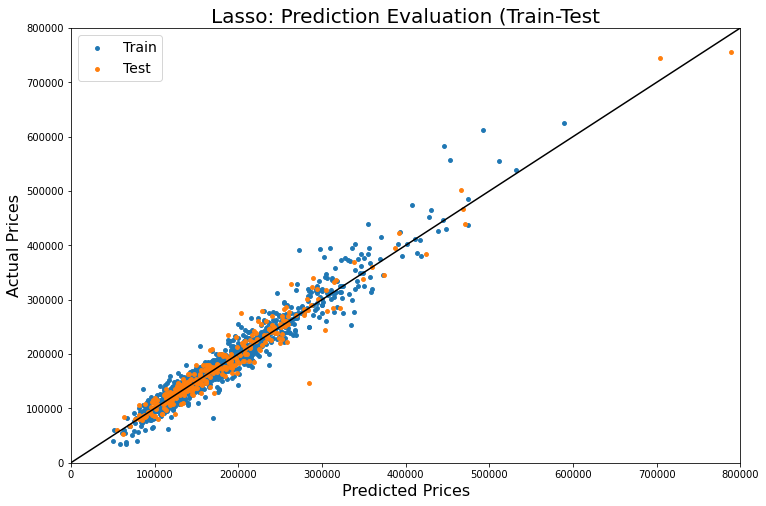

In [30]:
## plot error of train vs test data
plt.figure(figsize=(12,8))
plt.scatter(np.exp(ytrain_lasso), np.exp(ytrain), marker="o", s=15, label = "Train")
plt.scatter(np.exp(ytest_lasso), np.exp(ytest), marker="o", s=15, label="Test")
plt.title("Lasso: Prediction Evaluation (Train-Test", fontsize=20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.legend(loc = "upper left", fontsize = 14)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.plot([0, 800000], [0, 800000], 'black') # ideal predict-
#plt.show()
plt.savefig('../output/lasso_train_test_compare.png')

### _hyperparameter alpha selection for least overfit & plotting_

In [19]:
## manual grid search of Lasso: varying alpha

lasso = Lasso(normalize=True, max_iter=2000)
alphas = np.linspace(1e-5, 1e-2, 100)

coefs = []
scores_cv = []
scores_train = []

# loop through all alpha values to get lasso coefficients, cv scores, and train scores
for alpha in alphas:
    lasso.set_params(alpha = alpha)
    lasso.fit(xtrain, ytrain)
    coefs.append(lasso.coef_)
    
    lasso_score_cv = cross_val_score(estimator = lasso, X = xtrain, y = ytrain, cv = kf5)
    scores_cv.append(lasso_score_cv)
    
    lasso_score_train = lasso.score(xtrain, ytrain)
    scores_train.append(lasso_score_train)

In [20]:
# lasso coef & score dataframe
coefs_lasso = pd.DataFrame(coefs, index = alphas, columns = xtrain.columns)

# compute & align train and validation score of the Lasso model
scores_cv_lasso = pd.DataFrame(scores_cv, index = alphas, columns = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5'])
scores_cv_lasso['validation_score'] = scores_cv_lasso.mean(axis =1)
scores_train_lasso = pd.DataFrame(scores_train, index = alphas, columns=["train_score"])
scores_lasso = pd.concat([scores_cv_lasso.validation_score, scores_train_lasso], axis=1)
scores_lasso.head()

validation_score  train_score
0.000010          0.898988     0.945187
0.000111          0.909615     0.929758
0.000212          0.907189     0.920620
0.000313          0.901409     0.911185
0.000414          0.895685     0.902254

In [55]:
# find alpha for least overfit Lasso
scores_lasso['diff'] = abs(scores_lasso.train_score - scores_lasso.validation_score)
cv_train_close = scores_lasso[scores_lasso['diff'] == scores_lasso['diff'].min(axis = 0)] # closed train-validataion score
#print(best_alpha)
alpha_least_overfit = round(cv_train_close.iloc[0 ,2], ndigits=5)
print("Lasso least overfit alpha", alpha_least_overfit)

Lasso least overfit alpha 0.00017


array([0.87443593])

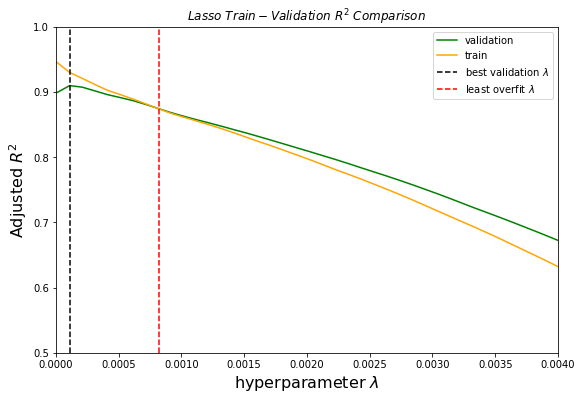

In [972]:
## Lasso plot: scores
plt.figure(figsize=(9,6))
scores_lasso['alpha'] = scores_lasso.index
plt.plot(scores_lasso.alpha, scores_lasso.validation_score, color = "green", label = "validation")
plt.plot(scores_lasso.alpha, scores_lasso.train_score, color = "orange", label = 'train')
plt.axvline(x = best_alpha, color = 'black', linestyle='dashed', label = r'best validation $\lambda$')
plt.axvline(x = alpha_least_overfit, color = 'red', linestyle='dashed', label = r"least overfit $\lambda$")
#ax.set_xscale('log')
plt.legend(loc = 1)
plt.title(r"$Lasso\ Train-Validation\ R^2\ Comparison$")
plt.xlim(0, 0.004)
plt.ylim(0.5, 1)
plt.xlabel(r'hyperparameter $\lambda$', fontsize = 16)
plt.ylabel(r"Adjusted $R^2$", fontsize = 16)
plt.savefig("../output/lasso_train_validation_score.png")

In [56]:
# Selected Lasso Model
model_lasso = Lasso(normalize=True, max_iter=2000, alpha=alpha_least_overfit)
model_lasso.fit(xtrain, ytrain)
print("Lasso model best alpha is", alpha_best_train)
print("Lasso model least overfit alpha is", alpha_least_overfit)
print("Lasso cross least overfit validation score:", round(cv_train_close.validation_score.values[0], ndigits=4))
print("Lasso train least overfit score", round(model_lasso.score(xtrain, ytrain), ndigits=4))

Lasso model best alpha is 0.00011
Lasso model least overfit alpha is 0.00017
Lasso cross least overfit validation score: 0.8744
Lasso train least overfit score 0.9243


In [23]:
# Lasso model error: MSE & RMSE
ytrain_lasso = model_lasso.predict(xtrain)
ytest_lasso = model_lasso.predict(xtest)

RMSE = round(np.sqrt(mean_squared_error(ytrain, ytrain_lasso)), ndigits = 4) # no written function, need to manually calculate
print("Least overfit Lasso model train RMSE is", RMSE)

MSE = round(mean_squared_error(ytrain, ytrain_lasso), ndigits=4)
print("Least overfit Lasso model train MSE is", MSE)

MSE2 = round(mean_squared_error(ytest, ytest_lasso), ndigits=4)
print("Least overfit Lasso model test MSE is", MSE)

Least overfit Lasso model train RMSE is 0.1095
Least overfit Lasso model train MSE is 0.012
Least overfit Lasso model test MSE is 0.012


In [24]:
# Lasso coefficients of significant predictors
lasso_coef = pd.DataFrame(model_lasso.coef_, index = xtrain.columns, columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
lasso_coef_abs = pd.DataFrame({'abs_coef':abs(model_lasso.coef_), 'coef': model_lasso.coef_}, index = xtrain.columns).sort_values(by = 'abs_coef', ascending = False)
lasso_coef_imp = lasso_coef_abs[lasso_coef_abs['abs_coef']>0]
print(f"number of predictors before Lasso:", lasso_coef_abs.shape[0])
print(f"number of predictors after Lasso:", lasso_coef_imp.shape[0])
lasso_coef_imp.to_csv("../output/lasso_coef_imp.csv") # coef is for raw data, not for normalized data
display(lasso_coef_imp)

number of predictors before Lasso: 224
number of predictors after Lasso: 67


abs_coef      coef
Exterior1st_brkcomm   0.102121 -0.102121
Neighborhood_crawfor  0.097396  0.097396
SaleType_new          0.092119  0.092119
Neighborhood_idotrr   0.075951 -0.075951
Neighborhood_meadowv  0.065971 -0.065971
MSSubClass_160        0.062435 -0.062435
OverallQual           0.059506  0.059506
Neighborhood_stonebr  0.058942  0.058942
Neighborhood_somerst  0.057647  0.057647
CentralAir_y          0.053735  0.053735
Neighborhood_nridght  0.050788  0.050788
SaleCondition_normal  0.040668  0.040668
MSZoning_rl           0.038145  0.038145
MSSubClass_30         0.037234 -0.037234
OverallCond           0.034314  0.034314
Condition1_norm       0.033125  0.033125
Exterior1st_brkface   0.031809  0.031809
KitchenAbvGr          0.030301 -0.030301
RoofMatl_membran      0.029875  0.029875
Street_pave           0.029116  0.029116
Heating_grav          0.028506 -0.028506
GarageCars            0.028461  0.028461
BldgType_twnhs        0.027726 -0.027726
KitchenQual           0.020721  0.020721
Neighborhood_brdale   0.020627 -0.020627
RoofStyle_gambrel     0.019823 -0.019823
Foundation_pconc      0.018314  0.018314
Fireplaces            0.017924  0.017924
Functional            0.016263  0.016263
LotConfig_culdsac     0.015821  0.015821
BsmtFullBath          0.015307  0.015307
LotShape_ir2          0.014226  0.014226
Neighborhood_oldtown  0.014172 -0.014172
ExterQual             0.014025  0.014025
HalfBath              0.012100  0.012100
BsmtExposure          0.010046  0.010046
MSZoning_fv           0.009827  0.009827
FullBath              0.008407  0.008407
GarageFinish          0.008123  0.008123
HeatingQC             0.007918  0.007918
GarageQual            0.006096  0.006096
RoofMatl_wdshngl      0.005301  0.005301
MasVnrType_stone      0.005092  0.005092
BsmtQual              0.003934  0.003934
FireplaceQu           0.003504  0.003504
BldgType_twnhse       0.003332 -0.003332
PavedDrive_y          0.002354  0.002354
LotShape_reg          0.001575 -0.001575
YearBuilt             0.001456  0.001456
BsmtFinType1          0.001188  0.001188
YearRemodAdd          0.000727  0.000727
YrSold                0.000546 -0.000546
Condition1_rrae       0.000471 -0.000471
GrLivArea             0.000253  0.000253
LotConfig_inside      0.000179 -0.000179
ScreenPorch           0.000107  0.000107
TotalBsmtSF           0.000093  0.000093
GarageArea            0.000081  0.000081
BsmtFinSF1            0.000071  0.000071
OpenPorchSF           0.000037  0.000037
WoodDeckSF            0.000030  0.000030
LowQualFinSF          0.000029 -0.000029
MasVnrArea            0.000025  0.000025
1stFlrSF              0.000013  0.000013
LotFrontage           0.000010  0.000010
BsmtFinSF2            0.000008  0.000008
LotArea               0.000002  0.000002

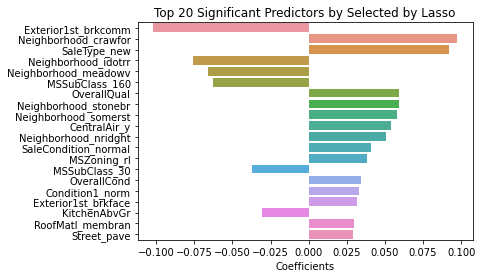

In [44]:
# plot of top significant coefficients
plot_df = lasso_coef_imp.iloc[:20, ]
#plot_df['sign'] = ["negative" if plot_df["coef"] < 0 else "positive" for x in plot_df["abs_coef"] ]
ax = sns.barplot(y = plot_df.index, x = "coef", data = plot_df)
ax.set(xlabel = "Coefficients", title = "Top 20 Significant Predictors by Selected by Lasso")
plt.savefig("../output/lasso_coef_imp_top20.png", bbox_inches = "tight")

## 2. Elastic Net
<a id='en'></a>

### _data frame set up_

In [25]:
## drop non-significant columns based on Lasso
df_reduce = df[lasso_coef_imp.index]
xtrain_reduce = xtrain[lasso_coef_imp.index]
xtest_reduce = xtest[lasso_coef_imp.index]
print("xtrain_reduce shape", xtrain_reduce.shape)

xtrain_reduce shape (1166, 67)


### _grid search of Elastic Net_

In [26]:
## Gridsearch of ElasticNet

# set hyperparameter space
#alphas = np.linspace(1e-10, 10, 100)
alphas = np.linspace(1e-6, 10, 100)
rhos = np.linspace(0.1, 1, 10)
rhos = np.append(rhos, np.linspace(0.91, 0.99, 9))
# set Elestic Net model
params_elasticnet = [{'alpha': alphas, 'l1_ratio': rhos, 'max_iter': [1000, 2000]}]
kf5 = KFold(n_splits=5, shuffle=True, random_state=4)
grid_elasticnet = GridSearchCV(estimator=ElasticNet(normalize=True), param_grid=params_elasticnet, cv=kf5,
                               return_train_score=True, refit=True, verbose = 2)
%time grid_elasticnet.fit(xtrain_reduce, ytrain)

Fitting 5 folds for each of 3800 candidates, totalling 19000 fits
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=2000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.1, max_iter=2000 ........................
[CV] ......

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......... alpha=1e-06, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.2, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.2, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.2, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.2, max_iter=2000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.2, max_iter=2000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.2, max_iter=2000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.2, max_iter=2000 ........................
[CV] .

[CV] ......... alpha=1e-06, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9, max_iter=1000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9, max_iter=2000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9, max_iter=2000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9, max_iter=2000 ........................
[CV] ......... alpha=1e-06, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.9, max_iter=2000 ........................
[CV] .

[CV] ........ alpha=1e-06, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.95, max_iter=1000 .......................
[CV] ........ alpha=1e-06, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.95, max_iter=1000 .......................
[CV] ........ alpha=1e-06, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.95, max_iter=1000 .......................
[CV] ........ alpha=1e-06, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.95, max_iter=2000 .......................
[CV] ........ alpha=1e-06, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.95, max_iter=2000 .......................
[CV] ........ alpha=1e-06, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.95, max_iter=2000 .......................
[CV] ........ alpha=1e-06, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1e-06, l1_ratio=0.95, max_iter=2000 .......................
[CV] .

[CV]  alpha=0.10101109090909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.10101109090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.30000000000000004, m

[CV]  alpha=0.10101109090909091, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.9, max_iter=1000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.9, max_iter=2000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.9, max_iter=2000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.9, max_iter=2000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.9, max_iter=2000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.9, max_iter=2000 ..........
[CV]  alpha=0.10101109090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=1

[CV]  alpha=0.10101109090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.95, max_iter=2000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.95, max_iter=2000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.95, max_iter=2000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.96, max_iter=1000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.96, max_iter=1000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_ratio=0.96, max_iter=1000 .........
[CV]  alpha=0.10101109090909091, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.10101109090909091, l1_

[CV]  alpha=0.20202118181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.20202118181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.20202118181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.20202118181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.20202118181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.20202118181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.30000000000000004, m

[CV]  alpha=0.20202118181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.9, max_iter=2000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.9, max_iter=2000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.9, max_iter=2000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.9, max_iter=2000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=1.0, max_iter=1000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=1.0, max_iter=1000 ..........
[CV]  alpha=0.20202118181818182, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=1

[CV]  alpha=0.20202118181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.95, max_iter=2000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.96, max_iter=1000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.96, max_iter=1000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.96, max_iter=1000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.96, max_iter=1000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_ratio=0.96, max_iter=1000 .........
[CV]  alpha=0.20202118181818182, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.20202118181818182, l1_

[CV]  alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.30000000000000004, max_iter=2000

[CV]  alpha=0.3030312727272727, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.3030312727272727, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=1.0, max_

[CV]  alpha=0.3030312727272727, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.3030312727272727, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.3030312727272727, l1_ratio=0.

[CV]  alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.30000000000000004, max_iter=2000

[CV]  alpha=0.4040413636363636, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.4040413636363636, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=1.0, max_

[CV]  alpha=0.4040413636363636, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.4040413636363636, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.4040413636363636, l1_ratio=0.

[CV]  alpha=0.5050514545454546, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.5050514545454546, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.5050514545454546, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.5050514545454546, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.5050514545454546, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.5050514545454546, l1_

[CV]  alpha=0.5050514545454546, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=0.5050514545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.9, max_

[CV]  alpha=0.5050514545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=0.5050514545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=0.5050514545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=0.5050514545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=0.5050514545454546, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=0.5050514545454546, l1_ratio=0.95, max

[CV]  alpha=0.6060615454545455, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=0.6060615454545455, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.2, max_

[CV]  alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alph

[CV]  alpha=0.6060615454545455, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.

[CV]  alpha=0.6060615454545455, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=0.6060615454545455, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=0.6060615454545455, l1_ratio=0.

[CV]  alpha=0.7070716363636363, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=0.7070716363636363, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.6, max_

[CV]  alpha=0.7070716363636363, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.

[CV]  alpha=0.7070716363636363, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=0.7070716363636363, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=0.7070716363636363, l1_ratio=0.

[CV]  alpha=0.8080817272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.4, max_

[CV]  alpha=0.8080817272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=0.8080817272727273, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=1.0, max_

[CV]  alpha=0.8080817272727273, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=0.8080817272727273, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=0.8080817272727273, l1_ratio=0.

[CV]  alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.30000000000000004, max_iter=2000

[CV]  alpha=0.9090918181818183, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=0.9090918181818183, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.9, max_

[CV]  alpha=0.9090918181818183, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=0.9090918181818183, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=0.9090918181818183, l1_ratio=0.

[CV]  alpha=1.0101019090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.2, max_

[CV]  alpha=1.0101019090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=1.0101019090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=1.0101019090909091, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.0101019090909091, l1_ratio=0.8, max_iter=1000, total=   0

[CV]  alpha=1.0101019090909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=1.0101019090909091, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=1.0101019090909091, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] a

[CV]  alpha=1.0101019090909091, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.0101019090909091, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.0101019090909091, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.

[CV]  alpha=1.1111119999999999, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=1.1111119999999999, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.6, max_

[CV]  alpha=1.1111119999999999, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.

[CV]  alpha=1.1111119999999999, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=1.1111119999999999, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=1.1111119999999999, l1_ratio=0.

[CV]  alpha=1.2121220909090908, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.5, max_iter=1000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.5, max_

[CV]  alpha=1.2121220909090908, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.2121220909090908, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.91, m

[CV]  alpha=1.2121220909090908, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.2121220909090908, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.2121220909090908, l1_ratio=0.

[CV]  alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=1.3131321818181818, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.4, max_iter=1000 ...........
[CV

[CV]  alpha=1.3131321818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=1.3131321818181818, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=1.0, max_

[CV]  alpha=1.3131321818181818, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=1.3131321818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=1.3131321818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=1.3131321818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=1.3131321818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=1.3131321818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=1.3131321818181818, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=1.3131321818181818, l1_ratio=0.

[CV]  alpha=1.4141422727272726, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.3000000

[CV]  alpha=1.4141422727272726, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=1.4141422727272726, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.8, max_

[CV]  alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.4141422727272726, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alph

[CV]  alpha=1.5151523636363635, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.1, max_

[CV]  alpha=1.5151523636363635, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=1.5151523636363635, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=1.5151523636363635, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=1.5151523636363635, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=1.5151523636363635, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=1.5151523636363635, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=1.5151523636363635, l1_ratio=0.7

[CV]  alpha=1.5151523636363635, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.

[CV]  alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=1.5151523636363635, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=1.5151523636363635, l1_ratio=0.

[CV]  alpha=1.6161624545454545, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=1.6161624545454545, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.6, max_

[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.

[CV]  alpha=1.6161624545454545, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=1.6161624545454545, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=1.6161624545454545, l1_ratio=0.

[CV]  alpha=1.7171725454545455, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.4, max_

[CV]  alpha=1.7171725454545455, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=1.0, max_iter=2000 ...........
[CV]  alpha=1.7171725454545455, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=1.0, max_

[CV]  alpha=1.7171725454545455, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=1.7171725454545455, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=1.7171725454545455, l1_ratio=0.

[CV]  alpha=1.8181826363636364, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=1.8181826363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=1.8181826363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=1.8181826363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=1.8181826363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=1.8181826363636364, l1_

[CV]  alpha=1.8181826363636364, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=1.8181826363636364, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.9, max_

[CV]  alpha=1.8181826363636364, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=1.8181826363636364, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=1.8181826363636364, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=1.8181826363636364, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha

[CV]  alpha=1.9191927272727272, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.2, max_

[CV]  alpha=1.9191927272727272, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=1.9191927272727272, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=1.9191927272727272, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=1.9191927272727272, l1_ratio=0.8, max_iter=1000, total=   0

[CV]  alpha=1.9191927272727272, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=1.9191927272727272, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=1.9191927272727272, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] a

[CV]  alpha=1.9191927272727272, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=1.9191927272727272, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=1.9191927272727272, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.1,

[CV]  alpha=2.0202028181818186, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=2.0202028181818186, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=2.0202028181818186, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=2.0202028181818186, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=

[CV]  alpha=2.0202028181818186, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.

[CV]  alpha=2.0202028181818186, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=2.0202028181818186, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.0202028181818186, l1_ratio=0.

[CV]  alpha=2.121212909090909, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=2.121212909090909, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.5, max_iter=200

[CV]  alpha=2.121212909090909, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.91, max_i

[CV]  alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.121212909090909, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.121212909090909, l1_ratio=0.97, max_

[CV]  alpha=2.222223, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.30000000000000004, max_iter=2000 .....
[CV]  alpha=2.222223, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.30000000000000004, max_iter=2000 .....
[CV]  alpha=2.222223, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.30000000000000004, max_iter=2000 .....
[CV]  alpha=2.222223, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.30000000000000004, max_iter=2000 .....
[CV]  alpha=2.222223, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.4, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.4, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_rat

[CV] ...... alpha=2.222223, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.9, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.9, max_iter=1000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.9, max_iter=2000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.9, max_iter=2000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.9, max_iter=2000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.9, max_iter=2000 .....................
[CV] ...... alpha=2.222223, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.9, max_iter=2000 .....................
[CV] .

[CV] ..... alpha=2.222223, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.97, max_iter=1000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.97, max_iter=1000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.97, max_iter=1000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.97, max_iter=1000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.97, max_iter=1000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.97, max_iter=2000 ....................
[CV] ..... alpha=2.222223, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=2.222223, l1_ratio=0.97, max_iter=2000 ....................
[CV] .

[CV]  alpha=2.323233090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=2.323233090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=2.323233090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.4, max_iter=1000, total=   0.0s


[CV]  alpha=2.323233090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=2.323233090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=2.323233090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=1.0, max_iter=100

[CV]  alpha=2.323233090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=2.323233090909091, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=2.323233090909091, l1_ratio=0.96, max_

[CV]  alpha=2.424243181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=2.424243181818182, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=2.424

[CV]  alpha=2.424243181818182, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=2.424243181818182, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.9, max_iter=100

[CV]  alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.424243181818182, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.42424318

[CV]  alpha=2.525253272727273, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.1, max_iter=200

[CV]  alpha=2.525253272727273, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=2.525253272727273, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=2.525253272727273, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=2.525253272727273, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=2.525253272727273, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=2.525253272727273, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=2.525253272727273, l1_ratio=0.7000000000000

[CV]  alpha=2.525253272727273, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.93, max_

[CV]  alpha=2.525253272727273, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=2.525253272727273, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.525253272727273, l1_ratio=0.99, max_

[CV]  alpha=2.626263363636364, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=2.626263363636364, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.6, max_iter=100

[CV]  alpha=2.626263363636364, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.91, max_

[CV]  alpha=2.626263363636364, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=2.626263363636364, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=2.626263363636364, l1_ratio=0.97, max_

[CV]  alpha=2.727273454545455, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=2.727273454545455, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=2.7272734

[CV]  alpha=2.727273454545455, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=2.727273454545455, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=2.727273454545455, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=1.0, max_iter=100

[CV]  alpha=2.727273454545455, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=2.727273454545455, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=2.727273454545455, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=2.727273454545455, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=2.727273454545455, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=2.727273454545455, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=2.727273454545455, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=2.727273454545455, l1_ratio=0.96, max_

[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.2, max_

[CV]  alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=2.8282835454545454, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.8, max_

[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=2.8282835454545454, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alph

[CV]  alpha=2.8282835454545454, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.1, max

[CV]  alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=2.9292936363636364, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=2.9292936363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=2.9292936363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=2.9292936363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=2.9292936363636364, l1_ratio=0.7000000000000001, ma

[CV]  alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.

[CV]  alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=2.9292936363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=2.9292936363636364, l1_ratio=0.

[CV]  alpha=3.0303037272727273, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.0303037272727273, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.0303037272727273, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.0303037272727273, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.5, max_iter=2000 ...........
[CV]  alpha=3.0303037272727273, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=3.0303037272727273, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=3.0303037272727273, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.6, max_

[CV]  alpha=3.0303037272727273, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.91, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.

[CV]  alpha=3.0303037272727273, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=3.0303037272727273, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=3.0303037272727273, l1_ratio=0.

[CV]  alpha=3.1313138181818183, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.1313138181818183, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.1313138181818183, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.1313138181818183, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.4,

[CV]  alpha=3.1313138181818183, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=3.1313138181818183, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=1.0, max_

[CV]  alpha=3.1313138181818183, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=3.1313138181818183, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.1313138181818183, l1_ratio=0.

[CV]  alpha=3.2323239090909093, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.2, max_

[CV]  alpha=3.2323239090909093, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=3.2323239090909093, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_

[CV]  alpha=3.2323239090909093, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=3.2323239090909093, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=3.2323239090909093, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=3.2323239090909093, l1_ratio=0.9400000000000001, max_iter=1000, to

[CV]  alpha=3.2323239090909093, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=3.2323239090909093, l1_ratio=0.99, max_iter=2000 ..........
[CV]  alpha=3.2323239090909093, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.1,

[CV]  alpha=3.3333340000000002, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.3333340000000002, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.3333340000000002, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.3333340000000002, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=3.3333340000000002, l1_ratio=0.8, max_it

[CV]  alpha=3.3333340000000002, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=3.3333340000000002, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.3333340000000002, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=3.3333340000000002, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha

[CV]  alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alph

[CV]  alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=3.434344090909091, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=3.434344090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=3.434344090909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=1.0, max_iter=100

[CV]  alpha=3.434344090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=3.434344090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.434344090909091, l1_ratio=0.95, max_

[CV]  alpha=3.535354181818182, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.2, max_iter=200

[CV]  alpha=3.535354181818182, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.535354181818182, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.535354181818182, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.535354181818182, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=3.535354181818182, l1_ratio=0.8, max_iter=1000, t

[CV]  alpha=3.535354181818182, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=3.535354181818182, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=3.535354181818182, l1_ra

[CV]  alpha=3.636364272727273, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=3.636364272727273, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.2, max_iter=100

[CV]  alpha=3.636364272727273, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=3.63636427272

[CV]  alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.636364272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=3.63636427

[CV]  alpha=3.7373743636363637, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.2, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.2, max_

[CV]  alpha=3.7373743636363637, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=3.7373743636363637, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.9, max_

[CV]  alpha=3.7373743636363637, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.96, max_iter=2000 ..........
[CV]  alpha=3.7373743636363637, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=3.7373743636363637, l1_ratio=0.

[CV]  alpha=3.8383844545454546, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=3.8383844545454546, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=3.8383844545454546, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=3.8383844545454546, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=3.8383844545454546, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=3.8383844545454546, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=3.

[CV]  alpha=3.8383844545454546, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.9, max_iter=1000 ...........
[CV]  alpha=3.8383844545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.9, max_

[CV]  alpha=3.8383844545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=3.8383844545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=3.8383844545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=3.8383844545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=3.8383844545454546, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=3.8383844545454546, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=3.8383844545454546, l1_ratio=0.95, max_iter=1000 ..........
[CV]  alpha=3.8383844545454546, 

[CV]  alpha=3.9393945454545456, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=3.9393945454545456, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.1, max_

[CV]  alpha=3.9393945454545456, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=3.9393945454545456, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=3.9393945454545456, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=3.9393945454545456, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=3.9393945454545456, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=3.9393945454545456, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=3.93939454545

[CV]  alpha=3.9393945454545456, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.93, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.

[CV]  alpha=3.9393945454545456, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.99, max_iter=1000 ..........
[CV]  alpha=3.9393945454545456, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=3.9393945454545456, l1_ratio=0.

[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=4.040404636363637, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.6, max_iter=100

[CV]  alpha=4.040404636363637, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.91, max_

[CV]  alpha=4.040404636363637, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=4.040404636363637, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.040404636363637, l1_ratio=0.97, max_

[CV]  alpha=4.1414147272727275, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.4, max_

[CV]  alpha=4.1414147272727275, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=4.1414147272727275, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=1.0, max_

[CV]  alpha=4.1414147272727275, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=4.1414147272727275, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.1414147272727275, l1_ratio=0.

[CV]  alpha=4.242424818181818, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.2, max_iter=200

[CV]  alpha=4.242424818181818, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=4.242424818181818, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.8, max_iter=200

[CV] alpha=4.242424818181818, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=4.242424818181818, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=4.242424818181818, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=4.242424818181818, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=4.242424818181818, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.940000000000000

[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=4.242424818181818, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.1, max_

[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=4.3434349090909095, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.7000000

[CV]  alpha=4.3434349090909095, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.91, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.

[CV]  alpha=4.3434349090909095, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.97, max_iter=1000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.97, max_iter=2000 ..........
[CV]  alpha=4.3434349090909095, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.3434349090909095, l1_ratio=0.

[CV] ...... alpha=4.444445, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.6, max_iter=1000 .....................
[CV] ...... alpha=4.444445, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.6, max_iter=1000 .....................
[CV] .

[CV] ..... alpha=4.444445, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.92, max_iter=2000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.92, max_iter=2000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.92, max_iter=2000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.93, max_iter=1000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.93, max_iter=1000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.93, max_iter=1000 ....................
[CV] ..... alpha=4.444445, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.444445, l1_ratio=0.93, max_iter=1000 ....................
[CV] .

[CV]  alpha=4.545455090909091, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=4.545455090909091, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=4.545455090909091, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=4.545455090909091, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=4.545455090909091, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=4.545455090909091, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=4.545455090909091, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.1, max_iter=200

[CV]  alpha=4.545455090909091, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=4.545455090909091, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=4.545455090909091, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=4.545455090909091, l1_ratio=0.7000000000000001, max_iter=1000

[CV]  alpha=4.545455090909091, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.93, max_

[CV]  alpha=4.545455090909091, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=4.545455090909091, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=4.545455090909091, l1_ratio=0.98, max_

[CV]  alpha=4.646465181818182, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=4.646465181818182, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.5, max_iter=200

[CV]  alpha=4.646465181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.91, max_

[CV]  alpha=4.646465181818182, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=4.646465181818182, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.646465181818182, l1_ratio=0.97, max_

[CV]  alpha=4.747475272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0

[CV]  alpha=4.747475272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=4.747475272727273, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=4.747475272727273, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=1.0, max_iter=200

[CV]  alpha=4.747475272727273, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.747475272727273, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.747475272727273, l1_ratio=0.96, max_

[CV]  alpha=4.848485363636364, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=4.848485363636364, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=4.848485363636364, l1_ratio=0.3000

[CV]  alpha=4.848485363636364, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=4.848485363636364, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=4.848485363636364, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=4.848485363636364, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=4.848485363636364, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=4.848485363636364, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=4.848485363636364, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.9, max_iter=100

[CV]  alpha=4.848485363636364, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=4.848485363636364, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=4.848485363636364, l1_ratio=0.96, max_

[CV]  alpha=4.949495454545454, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=4.949495454545454, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=4.949495454545454, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=4.949495454545454, l1_ratio=0.4, max_iter=1000, total=   0.0s


[CV]  alpha=4.949495454545454, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=4.949495454545454, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.91, max_iter=1

[CV]  alpha=4.949495454545454, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=4.949495454545454, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=4.949495454545454, l1_ratio=0.98, max_

[CV]  alpha=5.050505545454546, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.050505545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.5, max_iter=100

[CV]  alpha=5.050505545454546, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=5.050505545454546, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=5.050505545454546, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=5.050505545454546, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.050505545454546, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.050505545454546, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.050505545454546, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=1.0, max_iter=200

[CV]  alpha=5.050505545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=5.050505545454546, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=5.050505545454546, l1_ratio=0.96, max_

[CV]  alpha=5.151515636363636, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.151515636363636, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.151515636363636, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.151515636363636, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.151515636363636, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=5.151515636363636, l1_ratio=0.3000

[CV]  alpha=5.151515636363636, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=5.151515636363636, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.9, max_iter=100

[CV]  alpha=5.151515636363636, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=5.151515636363636, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=5.151515636363636, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=5.151515636363636, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=5.151515636363636, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=5.151515636363636, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.151515636363636, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=5.151515636363636, l1_ratio=0.

[CV]  alpha=5.252525727272728, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=5.252525727272728, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.2, max_iter=100

[CV]  alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=5.25252572

[CV]  alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.252525727272728, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=5.25252572

[CV]  alpha=5.353535818181818, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.2, max_iter=200

[CV]  alpha=5.353535818181818, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=5.353535818181818, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.9, max_iter=200

[CV]  alpha=5.353535818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=5.353535818181818, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=5.353535818181818, l1_ratio=0.96, max_

[CV]  alpha=5.45454590909091, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=5.45454590909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=5.45454590909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=5.45454590909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=5.45454590909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=5.45454590909091, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.4, max_iter=1000 .............
[CV]  alpha=5.45454590909

[CV]  alpha=5.45454590909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=1.0, max_iter=1000 .............
[CV]  alpha=5.45454590909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=1.0, max_iter=1000 .............
[CV]  alpha=5.45454590909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=1.0, max_iter=1000 .............
[CV]  alpha=5.45454590909091, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=1.0, max_iter=2000 .............
[CV]  alpha=5.45454590909091, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=1.0, max_iter=2000 .............
[CV]  alpha=5.45454590909091, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=1.0, max_iter=2000 .............
[CV]  alpha=5.45454590909091, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=1.0, max_iter=2000 ......

[CV]  alpha=5.45454590909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.97, max_iter=1000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.97, max_iter=1000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.97, max_iter=2000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.97, max_iter=2000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.97, max_iter=2000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.97, max_iter=2000 ............
[CV]  alpha=5.45454590909091, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=5.45454590909091, l1_ratio=0.97, max_iter=200

[CV] ...... alpha=5.555556, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.6, max_iter=1000 .....................
[CV] ...... alpha=5.555556, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.6, max_iter=1000 .....................
[CV] .

[CV] ..... alpha=5.555556, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.92, max_iter=2000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.92, max_iter=2000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.92, max_iter=2000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.93, max_iter=1000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.93, max_iter=1000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.93, max_iter=1000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.93, max_iter=1000 ....................
[CV] .

[CV] ..... alpha=5.555556, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=5.555556, l1_ratio=0.99, max_iter=2000 ....................
[CV] ..... alpha=5.555556, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.1, max_iter=2000 ....

[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=5.656566090909091, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.8, max_iter=200

[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=5.656566090909091, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=5.656566090909091, l1_ratio=0.96, max_

[CV]  alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=5.757576181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.757576181818182, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=5.757576181818182, l1_

[CV]  alpha=5.757576181818182, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=5.757576181818182, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.91, max_it

[CV]  alpha=5.757576181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=5.757576181818182, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=5.757576181818182, l1_ratio=0.98, max_

[CV]  alpha=5.858586272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.858586272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=5.858586272727273, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.858586272727273, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.858586272727273, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.858586272727273, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=5.858586272727273, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.5, max_iter=100

[CV]  alpha=5.858586272727273, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.92, max_

[CV]  alpha=5.858586272727273, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=5.858586272727273, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=5.858586272727273, l1_ratio=0.99, max_

[CV]  alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=5.95959636

[CV]  alpha=5.959596363636364, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=5.959596363636364, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=5.959596363636364, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=5.959596363636364, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=5.959596363636364, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=5.959596363636364, l1_ratio=0.95, max_iter=1000

[CV]  alpha=6.0606064545454545, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.2, max_iter=2000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=6.0606064545454545, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=6.060606454545454

[CV]  alpha=6.0606064545454545, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.8, max_iter=1000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.8, max_iter=2000 ...........
[CV]  alpha=6.0606064545454545, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.8, max_

[CV]  alpha=6.0606064545454545, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.93, max_iter=2000 ..........
[CV]  alpha=6.0606064545454545, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.0606064545454545, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.0606064545454545, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.0606064545454545, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.0606064545454545, l1_ratio=0.9400000000000001, max_iter=1000, to

[CV]  alpha=6.161616545454546, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.2, max_iter=100

[CV]  alpha=6.161616545454546, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=6.161616545454546, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.9, max_iter=200

[CV]  alpha=6.161616545454546, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=6.161616545454546, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=6.161616545454546, l1_ratio=0.96, max_

[CV]  alpha=6.2626266363636365, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=6.2626266363636365, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=6

[CV]  alpha=6.2626266363636365, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=6.2626266363636365, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=1.0, max_

[CV]  alpha=6.2626266363636365, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=6.2626266363636365, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.2626266363636365, l1_ratio=0.

[CV]  alpha=6.363636727272728, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.2, max_iter=200

[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.363636727272728, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.8, max_iter=200

[CV]  alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.363636727272728, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.36363672

[CV]  alpha=6.464646818181818, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.2, max_iter=200

[CV]  alpha=6.464646818181818, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=6.464646818181818, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.9, max_iter=200

[CV]  alpha=6.464646818181818, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=6.464646818181818, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=6.464646818181818, l1_ratio=0.96, max_

[CV]  alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=6.565656909090909, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=6.565656909090909, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=6.565656909090909, l1_

[CV]  alpha=6.565656909090909, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=6.565656909090909, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=6.565656909090909, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.91, max_iter=10

[CV]  alpha=6.565656909090909, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=6.565656909090909, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=6.565656909090909, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=6.565656909090909, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=6.565656909090909, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=6.565656909090909, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=6.565656909090909, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=6.565656909090909, l1_ratio=0.98, max_

[CV] ...... alpha=6.666667, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.5, max_iter=2000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.6, max_iter=1000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.6, max_iter=1000 .....................
[CV] ...... alpha=6.666667, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.6, max_iter=1000 .....................
[CV] .

[CV] ..... alpha=6.666667, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.91, max_iter=2000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.92, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.92, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.92, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.92, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.92, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.92, max_iter=2000 ....................
[CV] .

[CV] ..... alpha=6.666667, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.98, max_iter=2000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.98, max_iter=2000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.98, max_iter=2000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.99, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.99, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.99, max_iter=1000 ....................
[CV] ..... alpha=6.666667, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=6.666667, l1_ratio=0.99, max_iter=1000 ....................
[CV] .

[CV]  alpha=6.767677090909091, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=6.767677090909091, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=6.767677090909091, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=6.767677090909091, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=6.767677090909091, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=6.767677090909091, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=6.767677090909091, l1_rat

[CV]  alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.767677090909091, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.76767709

[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.300000000000000

[CV]  alpha=6.868687181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=6.868687181818182, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=1.0, max_iter=100

[CV]  alpha=6.868687181818182, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=6.868687181818182, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=6.868687181818182, l1_ratio=0.97, max_

[CV]  alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alph

[CV]  alpha=6.969697272727273, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=6.969697272727273, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9, max_iter=200

[CV]  alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=6.969697272727273, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.969697272727273, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.969697272727273, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=6.969697272727273, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=6.969697272727273, l1_ratio=0.95, max_iter=1000

[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=7.070707363636364, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.2, max_iter=100

[CV]  alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.07070736

[CV]  alpha=7.070707363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.93, max_

[CV]  alpha=7.070707363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=7.070707363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=7.070707363636364, l1_ratio=0.99, max_

[CV]  alpha=7.171717454545455, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=7.171717454545455, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.6, max_iter=100

[CV]  alpha=7.171717454545455, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.92, max_

[CV]  alpha=7.171717454545455, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=7.171717454545455, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=7.171717454545455, l1_ratio=0.97, max_

[CV]  alpha=7.272727545454546, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.4, max_iter=200

[CV]  alpha=7.272727545454546, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=7.272727545454546, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=7.272727545454546, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=1.0, max_iter=200

[CV]  alpha=7.272727545454546, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=7.272727545454546, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=7.272727545454546, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=7.272727545454546, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=7.272727545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=7.272727545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=7.272727545454546, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.272727545454546, l1_ratio=0.96, max_

[CV]  alpha=7.373737636363637, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=7.373737636363637, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=7.373737636363637, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=7.373737636363637, l1_ratio=0.30000000000000004, max_iter=1000, total=   0

[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=7.373737636363637, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.9, max_iter=100

[CV]  alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.373737636363637, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.37373763

[CV]  alpha=7.373737636363637, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.1, max_iter=20

[CV]  alpha=7.474747727272727, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=7.474747727272727, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.474747727272727, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.474747727272727, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.474747727272727, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[C

[CV]  alpha=7.474747727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.93, max_

[CV]  alpha=7.474747727272727, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=7.474747727272727, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=7.474747727272727, l1_ratio=0.99, max_

[CV]  alpha=7.575757818181819, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=7.575757818181819, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.5, max_iter=200

[CV]  alpha=7.575757818181819, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.92, max_

[CV]  alpha=7.575757818181819, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=7.575757818181819, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=7.575757818181819, l1_ratio=0.99, max_

[CV]  alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=7.67676790

[CV]  alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=7.676767909090909, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=7.67676790

[CV]  alpha=7.676767909090909, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.1, max_iter=1000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.1, max_iter=2000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.1, max_

[CV]  alpha=7.7777780000000005, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.6, max_iter=2000 ...........
[CV]  alpha=7.7777780000000005, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.7777780000000005, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.7777780000000005, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=7.7777780000000005, l1_ratio=0.7000000000000001, max_iter=1000, total=

[CV]  alpha=7.7777780000000005, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.92, max_iter=1000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.92, max_iter=2000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.

[CV]  alpha=7.7777780000000005, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.98, max_iter=1000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.98, max_iter=2000 ..........
[CV]  alpha=7.7777780000000005, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=7.7777780000000005, l1_ratio=0.

[CV]  alpha=7.878788090909091, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=7.878788090909091, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=7.878788090909091, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=7.878788090909091, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=7.878788090909091, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=7.878788090909091, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=7.878788090909091, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.5, max_iter=200

[CV]  alpha=7.878788090909091, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.91, max_

[CV]  alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=7.878788090909091, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=7.878788090909091, l1_ratio=0.97, max_

[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.4, max_

[CV]  alpha=7.9797981818181825, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.9, max_iter=2000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=1.0, max_iter=1000 ...........
[CV]  alpha=7.9797981818181825, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=1.0, max_

[CV]  alpha=7.9797981818181825, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.95, max_iter=2000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.96, max_iter=1000 ..........
[CV]  alpha=7.9797981818181825, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=7.9797981818181825, l1_ratio=0.

[CV]  alpha=8.080808272727273, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=8.080808272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=8.080808272727273, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=8.080

[CV]  alpha=8.080808272727273, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=8.080808272727273, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.9, max_iter=100

[CV]  alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=8.080808272727273, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=8.08080827

[CV]  alpha=8.181818363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=8.181818363636364, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.1, max_iter=200

[CV]  alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=8.18181836

[CV]  alpha=8.181818363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.93, max_

[CV]  alpha=8.181818363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=8.181818363636364, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=8.181818363636364, l1_ratio=0.99, max_

[CV]  alpha=8.282828454545454, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=8.282828454545454, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=8.282828454545454, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=8.282828454545454, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=8.282828454545454, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=8.282828454545454, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=8.282828454545454, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.6, max_iter=100

[CV]  alpha=8.282828454545454, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.91, max_

[CV]  alpha=8.282828454545454, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=8.282828454545454, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=8.282828454545454, l1_ratio=0.97, max_

[CV]  alpha=8.383838545454545, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=8.383838545454545, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.3838385

[CV]  alpha=8.383838545454545, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=8.383838545454545, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=8.383838545454545, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=1.0, max_iter=100

[CV]  alpha=8.383838545454545, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=8.383838545454545, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.383838545454545, l1_ratio=0.96, max_

[CV]  alpha=8.484848636363635, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.2, max_iter=200

[CV]  alpha=8.484848636363635, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=8.484848636363635, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.8, max_iter=200

[CV]  alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=8.48484863

[CV]  alpha=8.484848636363635, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=8.484848636363635, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=8.484848636363635, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.1, max_iter=1000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.1, max_iter=

[CV]  alpha=8.585858727272727, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.6, max_iter=2000 ............
[CV]  alpha=8.585858727272727, l1_ratio=0.6, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=8.585858727272727, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=8.585858727272727, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=8.585858727272727, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=8.585858727272727, l1_ratio=0.7000000000000001, max_iter=1000

[CV]  alpha=8.585858727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.92, max_iter=2000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.93, max_

[CV]  alpha=8.585858727272727, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=8.585858727272727, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=8.585858727272727, l1_ratio=0.99, max_

[CV]  alpha=8.686868818181818, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=8.686868818181818, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=8.686868818181818, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=8.686868818181818, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=8.686868818181818, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=8.686868818181818, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=8.686868818181818, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.6, max_iter=100

[CV]  alpha=8.686868818181818, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.92, max_

[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=8.686868818181818, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=8.686868818181818, l1_ratio=0.97, max_

[CV]  alpha=8.787878909090908, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=8.787878909090908, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=8.787878909090908, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.4, max_iter=1000, total=   0.0s


[CV]  alpha=8.787878909090908, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=8.787878909090908, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=8.787878909090908, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=8.787878909090908, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=1.0, max_iter=100

[CV]  alpha=8.787878909090908, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.95, max_iter=2000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=8.787878909090908, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.787878909090908, l1_ratio=0.96, max_

[CV]  alpha=8.888888999999999, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.2, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=8.888888999999999, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_rat

[CV]  alpha=8.888888999999999, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=8.888888999999999, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.8, max_iter=200

[CV]  alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=1000 
[CV]  alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=8.88888899

[CV]  alpha=8.888888999999999, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=8.888888999999999, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=8.888888999999999, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.1, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.1, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.1, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.1, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.1, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.1, max_iter=2000 ..

[CV]  alpha=8.98989909090909, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.8, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.8, max_iter=1000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.8, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.8, max_iter=2000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.8, max_iter=2000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.8, max_iter=2000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.8, max_iter=2000 .............
[CV]  alpha=8.98989909090909, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.8, max_iter=2000 ......

[CV]  alpha=8.98989909090909, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.95, max_iter=2000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.95, max_iter=2000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.95, max_iter=2000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.95, max_iter=2000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.95, max_iter=2000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.95, max_iter=2000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.96, max_iter=1000 ............
[CV]  alpha=8.98989909090909, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=8.98989909090909, l1_ratio=0.96, max_iter=100

[CV]  alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=9.090909181818182, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=9.090909181818182, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=9.090909181818182, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=9.090909181818182, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=9.090909181818182, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=9.090909181818182, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.0909091

[CV]  alpha=9.090909181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.91, max_

[CV]  alpha=9.090909181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=9.090909181818182, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=9.090909181818182, l1_ratio=0.98, max_

[CV]  alpha=9.191919272727272, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.5, max_iter=1000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.5, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=9.191919272727272, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.5, max_iter=200

[CV]  alpha=9.191919272727272, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=9.191919272727272, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=9.191919272727272, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=9.191919272727272, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=9.191919272727272, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=9.191919272727272, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.91, max_iter=1000 ...........
[CV]  alpha=9.191919272727272, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.91, max_ite

[CV]  alpha=9.191919272727272, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=9.191919272727272, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=9.191919272727272, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=9.191919272727272, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=9.191919272727272, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=9.191919272727272, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=9.191919272727272, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.191919272727272, l1_ratio=0.96, max_

[CV]  alpha=9.292929363636363, l1_ratio=0.2, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.292929363636363, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.292929363636363, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.292929363636363, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.292929363636363, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.292929363636363, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=9.292929363636

[CV]  alpha=9.292929363636363, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.8, max_iter=2000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=9.292929363636363, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.9, max_iter=100

[CV]  alpha=9.292929363636363, l1_ratio=0.9400000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.292929363636363, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.292929363636363, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.292929363636363, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.292929363636363, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.292929363636363, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.292929363636363, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=9.29292936363

[CV]  alpha=9.393939454545453, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.393939454545453, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.2, max_iter=100

[CV]  alpha=9.393939454545453, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.393939454545453, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.393939454545453, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.393939454545453, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.393939454545453, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.393939454545453, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.8, max_iter=1000 ............
[CV]  alpha=9.39393945454

[CV]  alpha=9.393939454545453, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.94000000

[CV]  alpha=9.393939454545453, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.99, max_iter=2000 ...........
[CV]  alpha=9.393939454545453, l1_ratio=0.99, max_iter=2000, total=   0.0s
[CV] alpha=9.393939454545453, l1_ratio=0.99, max_

[CV]  alpha=9.494949545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.5, max_iter=2000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.6, max_iter=1000 ............
[CV]  alpha=9.494949545454546, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.6, max_iter=100

[CV]  alpha=9.494949545454546, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.92, max_

[CV]  alpha=9.494949545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=9.494949545454546, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=9.494949545454546, l1_ratio=0.98, max_

[CV]  alpha=9.595959636363636, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=9.595959636363636, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=9.595959636363636, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.595959636363636, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.595959636363636, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.595959636363636, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.595959636363636, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.4, max_iter=200

[CV]  alpha=9.595959636363636, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.91, max_iter=2000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.92, max_iter=1000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.92, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.92, max_

[CV]  alpha=9.595959636363636, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.97, max_iter=2000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.98, max_iter=1000 ...........
[CV]  alpha=9.595959636363636, l1_ratio=0.98, max_iter=1000, total=   0.0s
[CV] alpha=9.595959636363636, l1_ratio=0.98, max_

[CV]  alpha=9.696969727272727, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.4, max_iter=1000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.4, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.4, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=0.4, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.5, max_iter=100

[CV]  alpha=9.696969727272727, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=9.696969727272727, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=1.0, max_iter=1000 ............
[CV]  alpha=9.696969727272727, l1_ratio=1.0, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=1.0, max_iter=2000 ............
[CV]  alpha=9.696969727272727, l1_ratio=1.0, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=1.0, max_iter=200

[CV]  alpha=9.696969727272727, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.96, max_iter=1000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.96, max_iter=1000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.96, max_iter=2000 ...........
[CV]  alpha=9.696969727272727, l1_ratio=0.96, max_iter=2000, total=   0.0s
[CV] alpha=9.696969727272727, l1_ratio=0.96, max_

[CV]  alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=1000 
[CV]  alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.30000000000000004, max_iter=2000 
[CV]  alph

[CV]  alpha=9.797979818181817, l1_ratio=0.8, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9, max_iter=1000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.9, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9, max_iter=2000 ............
[CV]  alpha=9.797979818181817, l1_ratio=0.9, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9, max_iter=200

[CV]  alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=2000 
[CV]  alpha=9.797979818181817, l1_ratio=0.9400000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.95, max_iter=1000, total=   0.0s
[CV] alpha=9.797979818181817, l1_ratio=0.95, max_iter=1000 ...........
[CV]  alpha=9.797979818181817, l1_ratio=0.95, max_iter=1000

[CV]  alpha=9.898989909090908, l1_ratio=0.1, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.898989909090908, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.898989909090908, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.898989909090908, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.898989909090908, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.1, max_iter=2000 ............
[CV]  alpha=9.898989909090908, l1_ratio=0.1, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.2, max_iter=1000 ............
[CV]  alpha=9.898989909090908, l1_ratio=0.2, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.2, max_iter=100

[CV]  alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=1000 
[CV]  alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.7000000000000001, max_iter=2000 
[CV]  alpha=9.89898990

[CV]  alpha=9.898989909090908, l1_ratio=0.92, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.93, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.93, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.93, max_iter=2000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.93, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.93, max_

[CV]  alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.98, max_iter=2000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.99, max_iter=1000 ...........
[CV]  alpha=9.898989909090908, l1_ratio=0.99, max_iter=1000, total=   0.0s
[CV] alpha=9.898989909090908, l1_ratio=0.99, max_

[CV] .......... alpha=10.0, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=2000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=2000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=2000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=2000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.5, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.6, max_iter=1000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.6, max_iter=1000 .........................
[CV] .......... alpha=10.0, l1_ratio=0.6, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.6, max_iter=1000 .........................
[CV] .

[CV] ......... alpha=10.0, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.91, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.91, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.91, max_iter=2000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.91, max_iter=2000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.91, max_iter=2000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.91, max_iter=2000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.91, max_iter=2000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.91, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.92, max_iter=1000 ........................
[CV] .

[CV] ......... alpha=10.0, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.97, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.97, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.97, max_iter=1000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.97, max_iter=1000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.97, max_iter=2000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.97, max_iter=2000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.97, max_iter=2000 ........................
[CV] ......... alpha=10.0, l1_ratio=0.97, max_iter=2000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.97, max_iter=2000 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 19000 out of 19000 | elapsed:  3.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=ElasticNet(normalize=True),
             param_grid=[{'alpha': array([1.00000000e-06, 1.01011091e-01, 2.02021182e-01, 3.03031273e-01,
       4.04041364e-01, 5.05051455e-01, 6.06061545e-01, 7.07071636e-01,
       8.08081727e-01, 9.09091818e-01, 1.01010191e+00, 1.11111200e+00,
       1.21212209e+00, 1.31313218e+00, 1.41414227e+0...
       8.48484864e+00, 8.58585873e+00, 8.68686882e+00, 8.78787891e+00,
       8.88888900e+00, 8.98989909e+00, 9.09090918e+00, 9.19191927e+00,
       9.29292936e+00, 9.39393945e+00, 9.49494955e+00, 9.59595964e+00,
       9.69696973e+00, 9.79797982e+00, 9.89898991e+00, 1.00000000e+01]),
                          'l1_ratio': array([0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.  , 0.91,
       0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                          'max_iter': [1000, 2000]}],
             return_train_score=True, verbose=2)

In [31]:
## best Elastic Net Model
model_elasticnet_best = grid_elasticnet.best_estimator_
print("Elastic Net best parameters are", grid_elasticnet.best_params_)
print("Elastic Net best alpha is", round(grid_elasticnet.best_params_['alpha'], ndigits=6))
print("Elastic Net best L1_ratio is", round(grid_elasticnet.best_params_['l1_ratio'], ndigits=4))
print("Elastic Net best validation score is", round(grid_elasticnet.best_score_, ndigits=4))
print("Elastic Net best training score is", round(model_elasticnet_best.score(xtrain_reduce,ytrain), ndigits=5))

Elastic Net best parameters are {'alpha': 1e-06, 'l1_ratio': 1.0, 'max_iter': 1000}
Elastic Net best alpha is 1e-06
Elastic Net best L1_ratio is 1.0
Elastic Net best validation score is 0.9147
Elastic Net best training score is 0.93191


In [32]:
###### grid_elasticnet.cv_results_['mean_train_score']
#for i in range(len(rho)*len(alpha)*1):
scores_en = pd.DataFrame({"parameters": grid_elasticnet.cv_results_['params'],
                     "train_score": grid_elasticnet.cv_results_['mean_train_score'], 
                     "validation_score": grid_elasticnet.cv_results_['mean_test_score']})
scores_en['alpha'] = scores_en.parameters.apply(lambda x: x['alpha'])
scores_en['l1_ratio'] = scores_en.parameters.apply(lambda x: x['l1_ratio'])
scores_en['score_diff'] = abs(scores_en.train_score - scores_en.validation_score)
scores_en.drop(['parameters'], axis = 1,inplace = True)
print(scores_en.shape)
#pd.unique(scores_en[['alpha', 'l1_ratio']].values.ravel('K'))
# param_combs = scores_en[['alpha', 'l1_ratio']].values.ravel()
# unique_param_comb = pd.unique(param_combs)
scores_en = scores_en.iloc[list(range(1,len(alphas)*len(rhos),2))]
scores_en_pos = scores_en[scores_en.train_score > 0]
scores_en_plot = pd.concat([scores_en_pos, scores_en.iloc[20:40,]], axis = 0)
scores_en_pos
en_least_overfit = scores_en_pos.loc[37,]
en_alpha_lof = en_least_overfit['alpha']
en_rho_lof = en_least_overfit['l1_ratio']
en_train_score_lof = en_least_overfit['train_score']
en_validation_score_lof = en_least_overfit['validation_score']
print("Elastic Net least overfit alpha", en_alpha_lof)
print('Elastic Net least overfit L1 ratio', en_rho_lof)
print('Elastic Net least overfit validation score', round(en_validation_score_lof, ndigits=4))
print('Elastic Net least overfit train score', round(en_train_score_lof, ndigits=4))
scores_en_pos

(3800, 5)
Elastic Net least overfit alpha 1e-06
Elastic Net least overfit L1 ratio 0.99
Elastic Net least overfit validation score 0.9147
Elastic Net least overfit train score 0.9338


train_score  validation_score     alpha  l1_ratio  score_diff
1      0.933766          0.914713  0.000001      0.10    0.019053
3      0.933766          0.914714  0.000001      0.20    0.019052
5      0.933766          0.914716  0.000001      0.30    0.019051
7      0.933766          0.914715  0.000001      0.40    0.019051
9      0.933766          0.914717  0.000001      0.50    0.019050
11     0.933766          0.914718  0.000001      0.60    0.019048
13     0.933766          0.914720  0.000001      0.70    0.019047
15     0.933766          0.914721  0.000001      0.80    0.019045
17     0.933766          0.914723  0.000001      0.90    0.019044
19     0.933766          0.914724  0.000001      1.00    0.019042
21     0.933766          0.914723  0.000001      0.91    0.019043
23     0.933766          0.914723  0.000001      0.92    0.019043
25     0.933766          0.914723  0.000001      0.93    0.019043
27     0.933766          0.914723  0.000001      0.94    0.019043
29     0.933766          0.914723  0.000001      0.95    0.019043
31     0.933766          0.914723  0.000001      0.96    0.019043
33     0.933766          0.914724  0.000001      0.97    0.019043
35     0.933766          0.914724  0.000001      0.98    0.019043
37     0.933766          0.914724  0.000001      0.99    0.019042
39     0.000718          0.000220  0.101011      0.10    0.000498

In [34]:
## Choose Elastic Net Model
model_elasticnet = ElasticNet(normalize=True, max_iter=1000, alpha= en_alpha_lof, 
                              l1_ratio = en_rho_lof)
model_elasticnet.fit(xtrain_reduce, ytrain)

ElasticNet(alpha=1e-06, l1_ratio=0.99, normalize=True)

In [786]:
# ## Elastic Net plot: scores
# # for name in scores_lasso.columns:
# #     plt.plot(scores_lasso.index, scores_lasso[name], label = name)
# plt.figure(figsize=(9,6))

# plt.plot(scores_en_plot.alpha, scores_en_plot.validation_score, color = "green", label = "validation")
# plt.plot(scores_en_plot.alpha, scores_en_plot.train_score, color = "orange", label = 'train')
# # plt.axvline(x = best_alpha, color = 'black', linestyle='dashed', label = r'best train $\lambda$')
# # plt.axvline(x = alpha_least_overfit, color = 'red', linestyle='dashed', label = r"least overfit $\lambda$")

# plt.legend(loc = 1)
# plt.title(r"$Elastic\ Net\ Train-Validation\ R^2\ Comparison$")
# # plt.xlim(0, 0.004)
# # plt.ylim(0.5, 1)
# plt.xlabel(r'hyperparameter $\lambda$', fontsize = 16)
# plt.ylabel(r"Adjusted $R^2$", fontsize = 16)
# # plt.savefig("../output/lasso_train_validation_score.png")

In [35]:
elasticnet = ElasticNet(normalize = True)
scores = np.zeros((len(rhos), len(alphas)))
for alphaIdx, alpha in enumerate(alphas):
    for rhoIdx, rho in enumerate(rhos):
        elasticnet.set_params(alpha = alpha, l1_ratio = rho)
        elasticnet.fit(xtrain_reduce, ytrain)
        scores[rhoIdx, alphaIdx] = elasticnet.score(xtrain_reduce, ytrain)

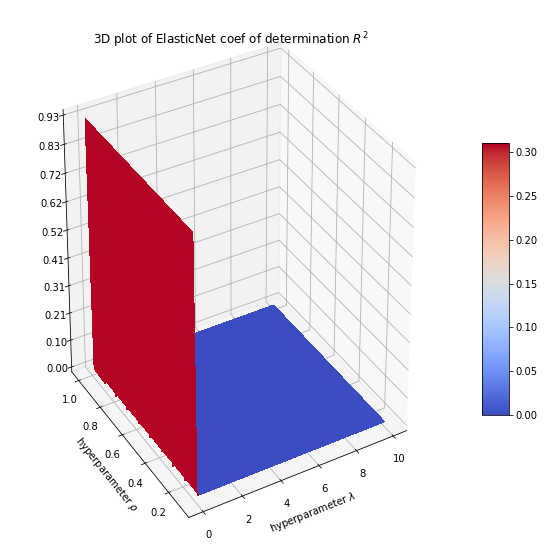

In [36]:
# Elastic Net plot: scores
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (10,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

X = alphas
Y = rhos
X, Y = np.meshgrid(X, Y)
Z = scores


# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
# ax.set_zlim(-0.1, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.title(r'3D plot of ElasticNet coef of determination $R^2$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'hyperparameter $\rho$')

ax.view_init(30,300)
# plt.savefig("../output/elasticnet_train_validation_score_30_300.png")
ax.view_init(30,270)
# plt.savefig("../output/elasticnet_train_validation_score_30_270.png")
ax.view_init(30,240)
# plt.savefig("../output/elasticnet_train_validation_score_30_240.png")

In [761]:
# ## Elastic Net Model Coefficients
# elasticnet_coef_abs = pd.DataFrame({'abs_coef':abs(model_elasticnet.coef_), 'coef': model_elasticnet.coef_}, 
#                               index = xtrain_reduce.columns).sort_values(by = 'abs_coef', ascending = False)
# elasticnet_coef_abs.to_csv("../output/elasticnet_coef_abs.csv")
# display(elasticnet_coef_abs)

In [ ]:
## Elastic Net 

In [942]:
# Elastic Net Error
ytrain_elasticnet = model_elasticnet.predict(xtrain_reduce)
ytest_elasticnet = model_elasticnet.predict(xtest_reduce)

RMSE = np.sqrt(mean_squared_error(ytrain, ytrain_elasticnet))
MSE = mean_squared_error(ytrain, ytrain_elasticnet)
print("Least overfit Elastic Net train MSE", round(MSE, ndigits=4))

MSE2 = mean_squared_error(ytest, ytest_elasticnet)
print("Least overfit Elastic Net test MSE", round(MSE2, ndigits=4))

Least overfit Elastic Net train MSE 0.0103
Least overfit Elastic Net test MSE 0.0113


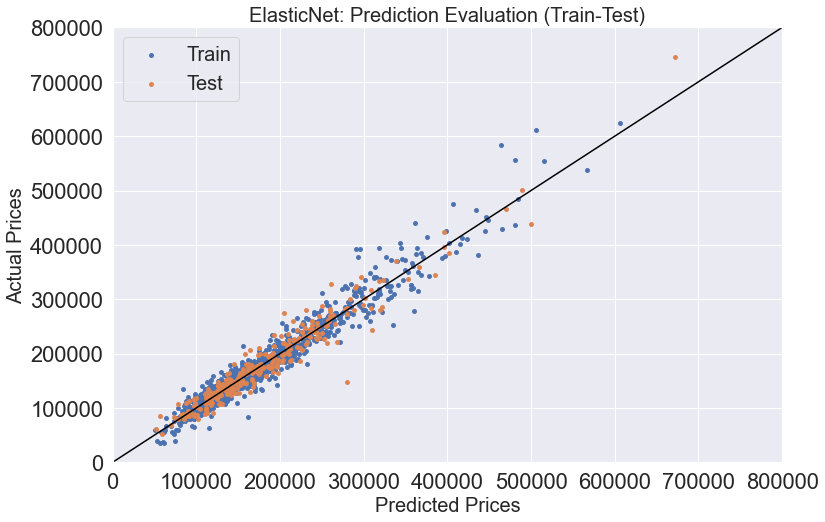

In [994]:
# Plot Elastic Nest Error
plt.figure(figsize=(12,8))
plt.scatter(np.exp(ytrain_elasticnet), np.exp(ytrain), marker="o", s=15, label = "Train")
plt.scatter(np.exp(ytest_elasticnet), np.exp(ytest), marker="o", s=15, label="Test")
plt.title("ElasticNet: Prediction Evaluation (Train-Test)", fontsize=20)
plt.xlabel("Predicted Prices", fontsize = 20)
plt.ylabel("Actual Prices", fontsize = 20)
plt.legend(loc = "upper left", fontsize = 20)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.plot([0, 800000], [0, 800000], 'black') # ideal predict-
#plt.show()
plt.savefig('../output/elasticnet_train_test_compare.png')

## 3. Random Forest
<a id='rf'></a>

### _data set preparation: categorical to numeric conversion_

In [99]:
# use ordinal data set
df = traino.copy()
drop_rows = df[df.index.isin([524, 1299])].index # high influential outliers of SalePrice, drop out reason stated in EDA
print("df shape before drop outlier rows:", df.shape) 
df.drop(drop_rows, inplace=True)
print("df shape after drop outlier rows:", df.shape)

df shape before drop outlier rows: (1460, 84)
df shape after drop outlier rows: (1458, 84)


In [100]:
# function to covert categorical data to integer
def text_to_num(x):
    '''get a column as param and return column coded in numeric
    from 1 to len of columns'''
    feature = set(x.to_list())
    #get a mapping of feature with their index from 1
    feature_dict = dict(zip( sorted(feature),range(1,len(feature)+1)))
    return x.map(feature_dict)

#get only categorical columns
text_col = df[~df.applymap(np.isreal)].dropna(axis=1).columns
#transform apply function on text columns and create a temp df
num_col = df[text_col].apply(text_to_num)
#Drop text column and merge data frame to create a full df.
tran_df = pd.concat((df.drop(text_col, axis = 1),num_col), axis=1)
print(tran_df.shape)
#tran_df.head()
'logSalePrice' in df.columns

(1458, 84)


True

In [124]:
## split to train & test for y is log Sale Price
xtrain, xtest, ytrain, ytest = train_test_split(tran_df.drop(['SalePrice', 'logSalePrice'], axis = 1), 
                                                tran_df.logSalePrice, test_size = 0.2, random_state = 4)

In [102]:
# ## split to train & test for y is sale price (test if tree model perform better on non linear distributed target data)
# xtrain, xtest, ytrain, ytest = train_test_split(tran_df.drop(['SalePrice', 'logSalePrice'], axis = 1), 
#                                                 tran_df.SalePrice, test_size = 0.2, random_state = 4)

### _random search for Random Forest_

In [125]:
## parameter tuning for random forest
params_rf = [{'max_features': range(20,51,10), 'n_estimators': range(200, 1001, 100), 
              'max_depth': range(0,81,10), 'min_samples_leaf': range(10,31,5)}]
kf5 = KFold(n_splits = 5, shuffle = True, random_state = 4)
random_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=4, oob_score = True), 
                               param_distributions = params_rf, return_train_score= True,
                               n_iter = 100, cv = kf5, verbose = 2, random_state=4)
%time random_rf.fit(xtrain, ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=200, min_samples_leaf=10, max_features=50, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_leaf=10, max_features=50, max_depth=10, total=   1.6s
[CV] n_estimators=200, min_samples_leaf=10, max_features=50, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=200, min_samples_leaf=10, max_features=50, max_depth=10, total=   1.3s
[CV] n_estimators=200, min_samples_leaf=10, max_features=50, max_depth=10 
[CV]  n_estimators=200, min_samples_leaf=10, max_features=50, max_depth=10, total=   1.5s
[CV] n_estimators=200, min_samples_leaf=10, max_features=50, max_depth=10 
[CV]  n_estimators=200, min_samples_leaf=10, max_features=50, max_depth=10, total=   2.2s
[CV] n_estimators=200, min_samples_leaf=10, max_features=50, max_depth=10 
[CV]  n_estimators=200, min_samples_leaf=10, max_features=50, max_depth=10, total=   1.9s
[CV] n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=80 
[CV]  n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=80, total=   4.2s
[CV] n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=80 
[CV]  n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=80, total=   4.2s
[CV] n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=80 
[CV]  n_es

[CV]  n_estimators=900, min_samples_leaf=30, max_features=20, max_depth=10, total=   6.5s
[CV] n_estimators=900, min_samples_leaf=30, max_features=20, max_depth=10 
[CV]  n_estimators=900, min_samples_leaf=30, max_features=20, max_depth=10, total=   4.6s
[CV] n_estimators=900, min_samples_leaf=30, max_features=20, max_depth=10 
[CV]  n_estimators=900, min_samples_leaf=30, max_features=20, max_depth=10, total=   4.7s
[CV] n_estimators=900, min_samples_leaf=30, max_features=20, max_depth=10 
[CV]  n_estimators=900, min_samples_leaf=30, max_features=20, max_depth=10, total=   5.1s
[CV] n_estimators=900, min_samples_leaf=25, max_features=20, max_depth=60 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=20, max_depth=60, total=   6.3s
[CV] n_estimators=900, min_samples_leaf=25, max_features=20, max_depth=60 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=20, max_depth=60, total=   5.0s
[CV] n_estimators=900, min_samples_leaf=25, max_features=20, max_depth=60 
[CV]  n_es

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=25, max_features=20, max_depth=0, total=   0.4s
[CV] n_estimators=600, min_samples_leaf=25, max_features=20, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=25, max_features=20, max_depth=0, total=   0.5s
[CV] n_estimators=600, min_samples_leaf=25, max_features=20, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=25, max_features=20, max_depth=0, total=   0.3s
[CV] n_estimators=600, min_samples_leaf=25, max_features=20, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=25, max_features=20, max_depth=0, total=   0.4s
[CV] n_estimators=600, min_samples_leaf=25, max_features=20, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=25, max_features=20, max_depth=0, total=   0.4s
[CV] n_estimators=800, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.5s
[CV] n_estimators=800, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.6s
[CV] n_estimators=800, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.5s
[CV] n_estimators=800, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.5s
[CV] n_estimators=800, min_samples_leaf=30, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=30, max_features=30, max_depth=0, total=   0.6s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=50, max_depth=40 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=50, max_depth=40, total=   7.3s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=50, max_depth=40 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=50, max_depth=40, total=   7.5s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=50, max_depth=40 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=50, max_depth=40, total=   7.3s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=50, max_depth=40 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=50, max_depth=40, total=   7.5s
[CV] n_estimators=1000, min_samples_leaf=15, max_features=50, max_depth=40 
[CV]  n_estimators=1000, min_samples_leaf=15, max_features=50, max_depth=40, total=   7.4s
[CV] n_estimators=700, min_samples_leaf=30, max_features=50, max_depth=50 
[

[CV]  n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=80, total=   5.1s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=20, max_depth=10 
[CV]  n_estimators=1000, min_samples_leaf=10, max_features=20, max_depth=10, total=   5.5s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=20, max_depth=10 
[CV]  n_estimators=1000, min_samples_leaf=10, max_features=20, max_depth=10, total=   5.5s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=20, max_depth=10 
[CV]  n_estimators=1000, min_samples_leaf=10, max_features=20, max_depth=10, total=   5.4s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=20, max_depth=10 
[CV]  n_estimators=1000, min_samples_leaf=10, max_features=20, max_depth=10, total=   5.2s
[CV] n_estimators=1000, min_samples_leaf=10, max_features=20, max_depth=10 
[CV]  n_estimators=1000, min_samples_leaf=10, max_features=20, max_depth=10, total=   5.4s
[CV] n_estimators=500, min_samples_leaf=15, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=50, max_depth=0, total=   0.4s
[CV] n_estimators=500, min_samples_leaf=15, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=500, min_samples_leaf=15, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=50, max_depth=0, total=   0.5s
[CV] n_estimators=500, min_samples_leaf=15, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=50, max_depth=0, total=   0.6s
[CV] n_estimators=500, min_samples_leaf=15, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=50, max_depth=0, total=   0.5s
[CV] n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=0, total=   0.5s
[CV] n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=0, total=   1.2s
[CV] n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=0, total=   0.7s
[CV] n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=0, total=   0.8s
[CV] n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=800, min_samples_leaf=30, max_features=40, max_depth=0, total=   0.4s
[CV] n_estimators=700, min_samples_leaf=20, max_features=20, max_depth=70 
[CV]  n_estimators=700, min_samples_leaf=20, max_features=20, max_depth=70, total=   3.0s
[CV] n_estimators=700, min_samples_leaf=20, max_features=20, max_depth=70 
[CV]  n_estimators=700, min_samples_leaf=20, max_features=20, max_depth=70, total=   3.0s
[CV] n_estimators=700, min_samples_leaf=20, max_features=20, max_depth=70 
[CV]  n_estimators=700, min_samples_leaf=20, max_features=20, max_depth=70, total=   3.3s
[CV] n_estimators=700, min_samples_leaf=20, max_features=20, max_depth=70 
[CV]  n_estimators=700, min_samples_leaf=20, max_features=20, max_depth=70, total=   2.9s
[CV] n_estimators=700, min_samples_leaf=20, max_features=20, max_depth=70 
[CV]  n_estimators=700, min_samples_leaf=20, max_features=20, max_depth=70, total=   2.4s
[CV] n_estimators=900, min_samples_leaf=20, max_features=50, max_depth=80 
[CV]  n_est

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=0, total=   0.3s
[CV] n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=0, total=   0.3s
[CV] n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=0, total=   0.4s
[CV] n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=0, total=   0.5s
[CV] n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=700, min_samples_leaf=30, max_features=20, max_depth=0, total=   0.5s
[CV] n_estimators=500, min_samples_leaf=10, max_features=30, max_depth=80 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=30, max_depth=80, total=   3.3s
[CV] n_estimators=500, min_samples_leaf=10, max_features=30, max_depth=80 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=30, max_depth=80, total=   2.4s
[CV] n_estimators=500, min_samples_leaf=10, max_features=30, max_depth=80 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=30, max_depth=80, total=   2.6s
[CV] n_estimators=500, min_samples_leaf=10, max_features=30, max_depth=80 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=30, max_depth=80, total=   2.1s
[CV] n_estimators=500, min_samples_leaf=10, max_features=30, max_depth=80 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=30, max_depth=80, total=   2.8s
[CV] n_estimators=400, min_samples_leaf=30, max_features=20, max_depth=80 
[CV]  n_est

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=300, min_samples_leaf=20, max_features=30, max_depth=0, total=   0.3s
[CV] n_estimators=300, min_samples_leaf=20, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=300, min_samples_leaf=20, max_features=30, max_depth=0, total=   0.2s
[CV] n_estimators=300, min_samples_leaf=20, max_features=30, max_depth=0 
[CV]  n_estimators=300, min_samples_leaf=20, max_features=30, max_depth=0, total=   0.2s
[CV] n_estimators=300, min_samples_leaf=20, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=300, min_samples_leaf=20, max_features=30, max_depth=0, total=   0.1s
[CV] n_estimators=400, min_samples_leaf=25, max_features=20, max_depth=80 
[CV]  n_estimators=400, min_samples_leaf=25, max_features=20, max_depth=80, total=   1.7s
[CV] n_estimators=400, min_samples_leaf=25, max_features=20, max_depth=80 
[CV]  n_estimators=400, min_samples_leaf=25, max_features=20, max_depth=80, total=   1.6s
[CV] n_estimators=400, min_samples_leaf=25, max_features=20, max_depth=80 
[CV]  n_estimators=400, min_samples_leaf=25, max_features=20, max_depth=80, total=   1.8s
[CV] n_estimators=400, min_samples_leaf=25, max_features=20, max_depth=80 
[CV]  n_estimators=400, min_samples_leaf=25, max_features=20, max_depth=80, total=   1.7s
[CV] n_estimators=400, min_samples_leaf=25, max_features=20, max_depth=80 
[CV]  n_estimators=400, min_samples_leaf=25, max_features=20, max_depth=80, total=   1.6s
[CV] n_estimators=400, min_samples_leaf=25, max_features=50, max_depth=50 
[CV]  n_est

[CV]  n_estimators=500, min_samples_leaf=25, max_features=50, max_depth=70, total=   5.3s
[CV] n_estimators=500, min_samples_leaf=10, max_features=20, max_depth=70 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=20, max_depth=70, total=   7.4s
[CV] n_estimators=500, min_samples_leaf=10, max_features=20, max_depth=70 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=20, max_depth=70, total=   6.1s
[CV] n_estimators=500, min_samples_leaf=10, max_features=20, max_depth=70 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=20, max_depth=70, total=   4.5s
[CV] n_estimators=500, min_samples_leaf=10, max_features=20, max_depth=70 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=20, max_depth=70, total=   3.1s
[CV] n_estimators=500, min_samples_leaf=10, max_features=20, max_depth=70 
[CV]  n_estimators=500, min_samples_leaf=10, max_features=20, max_depth=70, total=   2.1s
[CV] n_estimators=900, min_samples_leaf=25, max_features=20, max_depth=20 
[CV]  n_es

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=20, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=900, min_samples_leaf=20, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=20, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=900, min_samples_leaf=20, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=20, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=900, min_samples_leaf=20, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=20, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=900, min_samples_leaf=20, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=900, min_samples_leaf=20, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=800, min_samples_leaf=20, max_features=30, max_depth=20 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=30, max_depth=20, total=   4.3s
[CV] n_estimators=800, min_samples_leaf=20, max_features=30, max_depth=20 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=30, max_depth=20, total=   7.3s
[CV] n_estimators=800, min_samples_leaf=20, max_features=30, max_depth=20 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=30, max_depth=20, total=   7.4s
[CV] n_estimators=800, min_samples_leaf=20, max_features=30, max_depth=20 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=30, max_depth=20, total=   3.6s
[CV] n_estimators=800, min_samples_leaf=20, max_features=30, max_depth=20 
[CV]  n_estimators=800, min_samples_leaf=20, max_features=30, max_depth=20, total=   4.7s
[CV] n_estimators=1000, min_samples_leaf=20, max_features=40, max_depth=30 
[CV]  n_es

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=0, total=   0.4s
[CV] n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=0, total=   0.3s
[CV] n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=0, total=   0.3s
[CV] n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=0, total=   0.3s
[CV] n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=30, max_depth=0, total=   0.2s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=70 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=70, total=   4.9s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=70 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=70, total=   6.6s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=70 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=70, total=   5.6s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=70 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=70, total=   6.4s
[CV] n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=70 
[CV]  n_estimators=900, min_samples_leaf=25, max_features=50, max_depth=70, total=   6.5s
[CV] n_estimators=200, min_samples_leaf=30, max_features=40, max_depth=0 
[CV]  n_esti

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=200, min_samples_leaf=30, max_features=40, max_depth=0, total=   0.1s
[CV] n_estimators=200, min_samples_leaf=30, max_features=40, max_depth=0 
[CV]  n_estimators=200, min_samples_leaf=30, max_features=40, max_depth=0, total=   0.1s
[CV] n_estimators=200, min_samples_leaf=30, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=200, min_samples_leaf=30, max_features=40, max_depth=0, total=   0.1s
[CV] n_estimators=200, min_samples_leaf=30, max_features=40, max_depth=0 
[CV]  n_estimators=200, min_samples_leaf=30, max_features=40, max_depth=0, total=   0.2s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=30 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=30, total=   3.3s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=30 
[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=30, total=   3.0s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=30 
[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=30, total=   3.3s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=30 
[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=30, total=   2.0s
[CV] n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=30 
[CV]  n_estimators=500, min_samples_leaf=25, max_features=20, max_depth=30, total=   1.8s
[CV] n_estimators=800, min_samples_leaf=25, max_features=40, max_depth=50 
[CV]  n_estimators=800, min_samples_leaf=25, max_features=40, max_depth=50, total=   4.5s
[CV] n_estimators=800, min_samples_leaf=25, max_features=40, max_depth=50 
[CV]  n_es

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=300, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.1s
[CV] n_estimators=300, min_samples_leaf=25, max_features=50, max_depth=0 
[CV]  n_estimators=300, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.1s
[CV] n_estimators=300, min_samples_leaf=25, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=300, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.1s
[CV] n_estimators=300, min_samples_leaf=25, max_features=50, max_depth=0 
[CV]  n_estimators=300, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.2s
[CV] n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=10 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=10, total=   2.7s
[CV] n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=10 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=10, total=   2.7s
[CV] n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=10 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=10, total=   2.9s
[CV] n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=10 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=10, total=   2.8s
[CV] n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=10 
[CV]  n_estimators=600, min_samples_leaf=15, max_features=40, max_depth=10, total=   2.8s
[CV] n_estimators=600, min_samples_leaf=30, max_features=30, max_depth=10 
[CV]  n_estimators=600, min_samples_leaf=30, max_features=30, max_depth=10, total=   2.2s
[CV] n_estimators=600, min_samples_leaf=30, max_features=30, max_depth=10 
[CV]  n_es

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  n_estimators=200, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.1s
[CV] n_estimators=200, min_samples_leaf=25, max_features=50, max_depth=0 
[CV]  n_estimators=200, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.1s
[CV] n_estimators=200, min_samples_leaf=25, max_features=50, max_depth=0 
[CV]  n_estimators=200, min_samples_leaf=25, max_features=50, max_depth=0, total=   0.1s
[CV] n_estimators=300, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

[CV]  n_estimators=300, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.1s
[CV] n_estimators=300, min_samples_leaf=10, max_features=50, max_depth=0 
[CV]  n_estimators=300, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.1s
[CV] n_estimators=300, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=300, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.1s
[CV] n_estimators=300, min_samples_leaf=10, max_features=50, max_depth=0 
[CV]  n_estimators=300, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.1s
[CV] n_estimators=300, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=300, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.1s
[CV] n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=50 
[CV]  n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=50, total=   2.5s
[CV] n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=50 
[CV]  n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=50, total=   2.5s
[CV] n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=50 
[CV]  n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=50, total=   2.5s
[CV] n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=50 
[CV]  n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=50, total=   2.6s
[CV] n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=50 
[CV]  n_estimators=700, min_samples_leaf=30, max_features=30, max_depth=50, total=   2.6s
[CV] n_estimators=800, min_samples_leaf=30, max_features=20, max_depth=10 
[CV]  n_est

[CV]  n_estimators=400, min_samples_leaf=10, max_features=50, max_depth=30, total=   2.4s
[CV] n_estimators=600, min_samples_leaf=25, max_features=50, max_depth=50 
[CV]  n_estimators=600, min_samples_leaf=25, max_features=50, max_depth=50, total=   2.8s
[CV] n_estimators=600, min_samples_leaf=25, max_features=50, max_depth=50 
[CV]  n_estimators=600, min_samples_leaf=25, max_features=50, max_depth=50, total=   2.9s
[CV] n_estimators=600, min_samples_leaf=25, max_features=50, max_depth=50 
[CV]  n_estimators=600, min_samples_leaf=25, max_features=50, max_depth=50, total=   2.9s
[CV] n_estimators=600, min_samples_leaf=25, max_features=50, max_depth=50 
[CV]  n_estimators=600, min_samples_leaf=25, max_features=50, max_depth=50, total=   2.9s
[CV] n_estimators=600, min_samples_leaf=25, max_features=50, max_depth=50 
[CV]  n_estimators=600, min_samples_leaf=25, max_features=50, max_depth=50, total=   2.7s
[CV] n_estimators=700, min_samples_leaf=15, max_features=40, max_depth=40 
[CV]  n_es

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=600, min_samples_leaf=10, max_features=50, max_depth=0, total=   0.3s
[CV] n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0, total=   0.2s
[CV] n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0, total=   0.2s
[CV] n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0, total=   0.2s
[CV] n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0, total=   0.2s
[CV] n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  n_estimators=500, min_samples_leaf=15, max_features=40, max_depth=0, total=   0.2s
[CV] n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=10 
[CV]  n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=10, total=   1.4s
[CV] n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=10 
[CV]  n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=10, total=   1.3s
[CV] n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=10 
[CV]  n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=10, total=   1.3s
[CV] n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=10 
[CV]  n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=10, total=   1.3s
[CV] n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=10 
[CV]  n_estimators=300, min_samples_leaf=20, max_features=40, max_depth=10, total=   1.3s
[CV] n_estimators=800, min_samples_leaf=25, max_features=40, max_depth=30 
[CV]  n_est

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 29.9min finished


CPU times: user 23min 2s, sys: 32.4 s, total: 23min 34s
Wall time: 29min 56s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0...
                                

In [126]:
print("Random Forest best parameters are\n", random_rf.best_params_)
print("Random Forest best validation score is", round(random_rf.best_score_, ndigits=4)) # validation score
print("Random Forest best training score is", round(random_rf.score(xtrain, ytrain), ndigits=4))
print(random_rf.best_estimator_)

Random Forest best parameters are
 {'n_estimators': 700, 'min_samples_leaf': 10, 'max_features': 30, 'max_depth': 40}
Random Forest best validation score is 0.8587
Random Forest best training score is 0.9118
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=True,
                      random_state=4, verbose=0, warm_start=False)


In [127]:
scores_rf = pd.DataFrame({'parameters': random_rf.cv_results_['params'],
                         'validation_score':random_rf.cv_results_['mean_test_score'],
                         "train_score":random_rf.cv_results_['mean_train_score']})
scores_rf['score_diff'] = abs(scores_rf.validation_score - scores_rf.train_score)
scores_rf[scores_rf.score_diff == scores_rf.score_diff.min()]['parameters'].values
rf_least_overfit_idx = scores_rf[scores_rf.score_diff == scores_rf.score_diff.min()].index.values.tolist()
rf_least_overfit = scores_rf.iloc[rf_least_overfit_idx]
rf_least_overfit = scores_rf.iloc[61,]

rf_train_score_lof = rf_least_overfit['train_score']
rf_validation_score_lof = rf_least_overfit['validation_score']
rf_params_lof = rf_least_overfit['parameters']
print("Random Forest least overfit train score", round(rf_train_score_lof, ndigits=4))
print("Random Forest least overfit validation score", round(rf_validation_score_lof, ndigits=4))
print("Random Forest least overfit parameters", rf_params_lof)

rf_min_samples_leaf_lof = rf_params_lof['min_samples_leaf']
rf_max_features_lof = rf_params_lof['max_features']
rf_max_depth_lof = rf_params_lof['max_depth']
rf_n_estimators_lof = rf_params_lof['n_estimators']

Random Forest least overfit train score 0.8809
Random Forest least overfit validation score 0.8443
Random Forest least overfit parameters {'n_estimators': 800, 'min_samples_leaf': 15, 'max_features': 20, 'max_depth': 20}


In [128]:
# Set Random Forest Model
# model_rf = random_rf.best_estimator_ # choose the best validation score model
model_rf = RandomForestRegressor(n_estimators=rf_n_estimators_lof, min_samples_leaf=rf_min_samples_leaf_lof, 
                                 max_features=rf_max_features_lof, max_depth=rf_max_depth_lof) # choose the least overfit model
model_rf.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=20, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=15,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [129]:
pd.DataFrame({'train': ytrain, 'estimate': ytrain_rf})

train       estimate
Id                           
668   12.17303  204351.421085
227   12.57764  277236.276441
156   11.27720   91944.613160
232   12.90669  337572.804051
903   12.10071  181997.676747
725   12.67608  346875.823333
730   11.54248  107611.247039
386   12.16525  200927.554310
835   11.84904  140327.412788
859   11.93164  167182.419362
1123  11.62625  104641.443454
862   11.78676  138191.346056
448   12.20557  214094.552269
600   11.92504  165681.116926
45    11.85652  135431.745453
678   11.60368  119344.206469
1083  12.16525  202426.714838
1128  12.46458  246691.142866
674   12.45877  216072.695784
544   11.79810  146718.002247
334   12.24047  199070.610037
503   11.84940  138846.014826
790   12.14153  192089.008732
240   11.63514  135032.270226
669   12.03172  163534.210591
654   11.81303  131825.690889
34    12.01673  176427.394800
1222  11.80560  134513.207647
1432  11.87583  140328.103453
975   12.02874  183574.266417
125   12.10625  180316.892847
291   12.35978  249076.223699
438   11.68688  120633.390789
889   12.49874  270132.893652
165   11.93164  146246.483653
337   12.84113  355445.568189
367   11.97666  165543.073180
707   12.61818  246059.684411
657   11.88793  145367.924205
1254  12.59134  240787.420490
638   11.44035  118897.540985
513   11.77452  124081.401713
662   12.90421  341451.526089
50    11.75194  128254.396327
1381  10.97678   90952.898941
377   11.90497  145049.425343
1016  12.33271  212885.797962
1132  11.44572  125598.487398
784   12.01673  156050.406749
755   11.95761  142542.105967
67    12.10071  230284.536630
151   11.71178  134741.051104
578   12.01067  158395.800392
1106  12.69158  308795.798825
577   11.88449  144597.297390
528   13.00866  378559.664286
1079  11.95697  152120.991805
1446  11.76757  122721.481532
757   12.26434  226792.013602
331   11.68688  144657.417090
945   11.83138  154369.265722
941   11.92437  166896.131803
36    12.64110  311104.397482
1368  11.75194  143905.511629
1441  12.16003  197387.771581
664   11.83138  143711.595762
342   11.31447   97316.160217
517   11.97035  180587.800873
1146  11.91170  139910.109943
1204  12.26905  216903.604833
1090  12.19096  219320.770616
1127  12.06681  211765.759795
774   11.64833  121807.331379
1447  11.96972  143697.574697
873   11.66135  126339.347773
239   12.66981  309159.715692
546   12.34148  254631.495574
622   12.38839  211065.073141
509   11.98916  152351.228705
238   12.17819  197255.097662
1263  11.99226  153745.354465
1320  11.61729  118033.127595
1029  11.56172  127300.405381
39    11.59910  131650.709734
105   12.04061  163983.633292
888   11.81673  127797.160394
229   11.73607  128268.630181
892   12.05815  169415.575953
910   12.06681  177251.935550
899   13.32393  405914.202954
613   12.47419  249350.370952
271   12.49125  271156.739324
1235  11.77529  131813.127434
760   12.57764  311709.836655
743   12.09514  181387.329789
1041  11.95118  178145.681301
1230  11.75194  143310.332747
1383  11.96400  156749.192186
590   11.28351  106103.234909
1411  12.34583  221437.650846
128   11.37366  105590.101684
928   12.07824  192652.498071
3     12.31717  216243.370985
996   11.70849  112630.965865
1087  11.33260  103922.290859
430   12.07254  183703.205467
207   11.87687  159966.318068
1166  12.35952  218706.895784
706   10.91509   91958.937029
519   12.25961  194179.571412
986   11.73607  127130.596963
568   12.27373  214434.934205
421   12.23709  206473.000030
257   12.24289  200303.390578
1229  12.81392  348470.777454
262   12.52816  334171.611386
626   11.98293  141678.482058
839   11.87757  145192.728685
729   11.60824  162543.144867
611   12.65396  322614.269129
162   12.92999  367931.455079
1185  12.13726  195878.063920
400   12.39255  201653.418011
1377  11.41861  101030.497389
1281  12.33271  220709.285006
951   11.76757  135101.815543
833   12.37582  223479.403003
726   11.69941  124471.907610
1426  11.86358  148291.419013
1116  12.66981  329129.269894
280   12.16525  202292.262621
598   12.17665  209

In [130]:
# Random Forest Error
ytrain_rf = model_rf.predict(xtrain)
ytest_rf = model_rf.predict(xtest)

RMSE = np.sqrt(mean_squared_error(ytrain, ytrain_rf))
MSE = mean_squared_error(ytrain, ytrain_rf)
print("Least overfit Elastic Net train MSE", round(MSE, ndigits=4))

MSE2 = mean_squared_error(ytest, ytest_rf)
print("Least overfit Elastic Net test MSE", round(MSE2, ndigits=4))

Least overfit Elastic Net train MSE 0.0179
Least overfit Elastic Net test MSE 0.0203


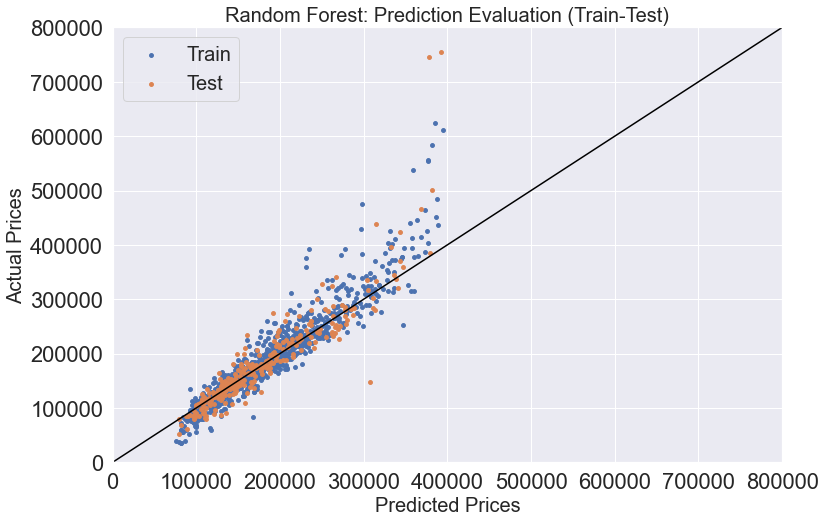

In [135]:
# plot for random forest
## plot error of train vs validataion data
sns.set(font_scale = 2)
plt.figure(figsize=(12,8))
plt.scatter(np.exp(ytrain_rf), np.exp(ytrain), marker="o", s=15, label = "Train")
plt.scatter(np.exp(ytest_rf), np.exp(ytest), marker="o", s=15, label="Test")
# plt.scatter(ytrain_rf, ytrain, marker="o", s=15, label = "Train") # for y is sale price
# plt.scatter(ytest_rf, ytest, marker="o", s=15, label="Test") # for y is sale price
plt.title("Random Forest: Prediction Evaluation (Train-Test)", fontsize=20)
plt.xlabel("Predicted Prices", fontsize = 20)
plt.ylabel("Actual Prices", fontsize = 20)
plt.legend(loc = "upper left", fontsize = 20)
plt.plot([0, 800000], [0, 800000], 'black') # ideal predict
plt.xlim(0, 800000)
plt.ylim(0, 800000)
#plt.show()
plt.savefig('../output/randomforest_train_test_compare.png')
# plt.savefig('../output/randomforest_train_test_compare_forSalePrice.png') # for y is sale price

### _the least overfit random forest_

In [804]:
rfreg = RandomForestRegressor(random_state=4, max_features=30, oob_score = True, 
                              n_estimators = 1000, min_samples_leaf = 10, max_depth = 20)
rfreg.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=4, verbose=0, warm_start=False)

In [805]:
# random forest prediction
randomforest_pred_train = rfreg.predict(xtrain)
randomforest_pred_test = rfreg.predict(xtest)
MSE = mean_squared_error(ytrain, randomforest_pred_train)
print(f"MSE is {MSE}")
print("train score is", rfreg.score(xtrain, ytrain))
print("oob score is", rfreg.oob_score_)

k5 = KFold(5, random_state=4, shuffle=True)
cv_score = cross_val_score(rfreg, xtrain, ytrain, cv = k5).mean()
print("validation score is", cv_score)

feature_importance = list(zip(xtrain.columns[:], rfreg.feature_importances_))
rf_feature_imp = pd.DataFrame(feature_importance, columns = ["predictor", "importance"]).sort_values(by = "importance", ascending=False)
#rf_feature_imp.to_csv("../output/rf_feature_imp.csv")
display(rf_feature_imp)

MSE is 0.013973422658244404
train score is 0.9117141478907913
oob score is 0.8623413277609362
validation score is 0.8589083018632578


predictor  importance
4           OverallQual    0.269430
24            GrLivArea    0.151948
9             ExterQual    0.089655
31          KitchenQual    0.054393
6             YearBuilt    0.044665
39           GarageArea    0.043473
38           GarageCars    0.042628
19          TotalBsmtSF    0.040120
21             1stFlrSF    0.034312
52     decade_YearBuilt    0.020962
11             BsmtQual    0.019074
35          FireplaceQu    0.017164
15           BsmtFinSF1    0.017142
27             FullBath    0.013993
2               LotArea    0.013884
76           GarageType    0.012268
37         GarageFinish    0.011791
74           CentralAir    0.010354
22             2ndFlrSF    0.009643
34           Fireplaces    0.008235
7          YearRemodAdd    0.008057
36          GarageYrBlt    0.007414
5           OverallCond    0.006783
32         TotRmsAbvGrd    0.006319
14         BsmtFinType1    0.004744
54   decade_GarageYrBlt    0.003595
8            MasVnrArea    0.003371
62         Neighborhood    0.002652
41           GarageCond    0.002417
1           LotFrontage    0.002347
0            MSSubClass    0.002245
53  decade_YearRemodAdd    0.002227
18            BsmtUnfSF    0.002078
55             MSZoning    0.001710
43          OpenPorchSF    0.001673
40           GarageQual    0.001658
77           PavedDrive    0.001549
29         BedroomAbvGr    0.001468
28             HalfBath    0.001341
42           WoodDeckSF    0.001133
13         BsmtExposure    0.000920
66           HouseStyle    0.000726
58             LotShape    0.000685
69          Exterior1st    0.000658
25         BsmtFullBath    0.000650
70          Exterior2nd    0.000616
30         KitchenAbvGr    0.000604
51               YrSold    0.000549
12             BsmtCond    0.000545
20            HeatingQC    0.000540
50               MoSold    0.000499
81        SaleCondition    0.000463
65             BldgType    0.000458
72           Foundation    0.000344
10            ExterCond    0.000268
75           Electrical    0.000266
71           MasVnrType    0.000245
67            RoofStyle    0.000186
44        EnclosedPorch    0.000165
80             SaleType    0.000137
3             LandSlope    0.000111
61            LotConfig    0.000101
63           Condition1    0.000095
78                Fence    0.000083
59          LandContour    0.000056
17           BsmtFinSF2    0.000043
16         BsmtFinType2    0.000043
46          ScreenPorch    0.000020
33           Functional    0.000005
49              MiscVal    0.000000
68             RoofMatl    0.000000
23         LowQualFinSF    0.000000
26         BsmtHalfBath    0.000000
64           Condition2    0.000000
60            Utilities    0.000000
73              Heating    0.000000
45            3SsnPorch    0.000000
57                Alley    0.000000
47             PoolArea    0.000000
79          MiscFeature    0.000000
48               PoolQC    0.000000
56               Street    0.000000

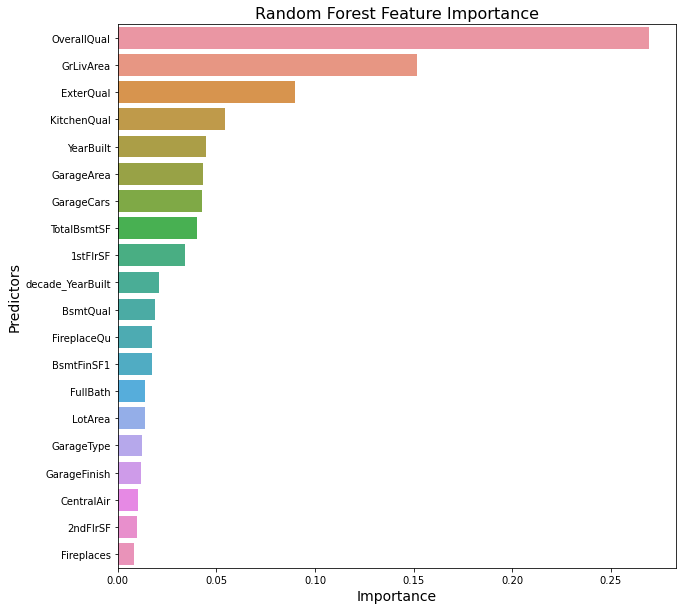

In [812]:
sns.barplot(y = 'predictor', x = 'importance', data = rf_feature_imp[:20])
plt.title("Random Forest Feature Importance", fontsize = 16)
plt.xlabel("Importance", fontsize = 14)
plt.ylabel("Predictors", fontsize = 14)
plt.savefig("../output/randomforest_feature_importance.png")

## Predictive Model Comparison

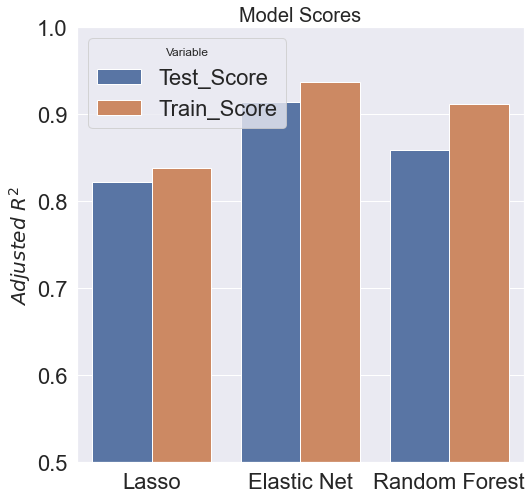

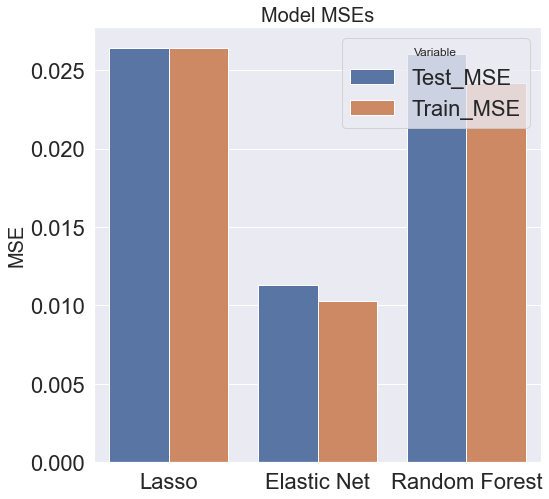

In [989]:
model_score = pd.DataFrame({"Test_Score":[0.8225, 0.9139, 0.8589], "Train_Score": [0.8386, 0.9368, 0.9117],
               "Model": ['Lasso', "Elastic Net", "Random Forest"]})
model_mse = pd.DataFrame({"Test_MSE": [0.0264, 0.0113, 0.026], "Train_MSE": [0.0264, 0.0103, 0.0242], 
             "Model": ['Lasso', "Elastic Net", "Random Forest"]})

# sns.barplot(x='Model', y='Train_Score', data=model_score)
sns.set(font_scale = 2)
fig1,ax1 = plt.subplots(figsize=(8,8))
tidy_score = model_score.melt(id_vars = "Model").rename(columns=str.title)
g = sns.barplot(x='Model', y='Value', hue='Variable', data = tidy_score, ax=ax1)
plt.title("Model Scores", fontsize = 20)
plt.ylim(0.5, 1.0)
plt.xlabel("", fontsize = 20)
plt.ylabel(r"$Adjusted\ R^2$", fontsize = 20)
# for index, row in tidy_score.iterrows():
#     g.text(row.name, row.Value, row.Value, color = 'black', ha='center')
plt.savefig("../output/model_compare_score.png")

sns.set(font_scale = 2)
fig2,ax2 = plt.subplots(figsize=(8,8))
tidy_mse = model_mse.melt(id_vars = "Model").rename(columns=str.title)
sns.barplot(x='Model', y='Value', hue='Variable', data = tidy_mse, ax=ax2)
plt.title("Model MSEs", fontsize = 20)
plt.xlabel("", fontsize = 16)
plt.ylabel(r"MSE", fontsize = 20)
plt.savefig("../output/model_compare_mse.png")

# display(model_score)
# display(model_mse)
# display(tidy_score)

## 4. Multiple Linear Regression 
_**home improvement for homeowners**_
<a id='mlr'></a>

In [10]:
# input data
mlr_data = pd.read_csv('../processed_data/train_mlr2.csv')
print(mlr_data.shape)
mlr_data.head()

(1460, 31)


Id  OverallQual  OverallCond  KitchenQual  GarageCars  Functional  \
0   1            7            5            4           2           8   
1   2            6            8            3           2           8   
2   3            7            5            4           2           8   
3   4            7            5            4           3           8   
4   5            8            5            4           3           8   

   Fireplaces  BsmtExposure  GarageFinish  GarageQual  BsmtQual  HeatingQC  \
0           0             1             2           3         4          5   
1           1             4             2           3         4          5   
2           1             2             2           3         4          5   
3           1             1             1           3         3          4   
4           1             3             2           3         4          5   

   ExterQual  FireplaceQu  BsmtFinType1  BsmtFinType2  TotRmsAbvGrd  \
0          4            0             6             1             8   
1          3            3             5             1             6   
2          4            3             6             1             6   
3          3            4             5             1             7   
4          4            3             6             1             9   

   BsmtFinSF1  MasVnrArea  BsmtFinSF2  KitchenAbvGr  Outdoor_Rec  \
0         706         196           0             1           61   
1         978           0           0             1          298   
2         486         162           0             1           42   
3         216           0           0             1          307   
4         655         350           0             1          276   

   Total_Fullbath  Total_Halfbath  Total_House_Area   FinBsmt  SalePrice  \
0               3               1              2566  0.824766     208500   
1               2               1              2524  0.774960     181500   
2               3               1              2706  0.528261     223500   
3               2               0              2473  0.285714     140000   
4               3               1              3343  0.572052     250000   

   logSalePrice  CentralAir_y  PavedDrive_p  PavedDrive_y  
0     12.247694             1             0             1  
1     12.109011             1             0             1  
2     12.317167             1             0             1  
3     11.849398             1             0             1  
4     12.429216             1             0             1

In [11]:
# drop columns and outliers
mlr_data.drop([1298,523], inplace=True)

mlr_data.drop(['Id',
               'OverallCond',
               'SalePrice',
               'BsmtFinSF1',
               'BsmtFinSF2'], axis=1, inplace=True)
mlr_data.shape

(1458, 26)

In [12]:
# train test split
mlr_X = mlr_data.drop('logSalePrice', axis=1)
mlr_y = mlr_data.logSalePrice

mlr_Xtrain, mlr_Xtest, mlr_ytrain, mlr_ytest = train_test_split(mlr_X, mlr_y, test_size=.2, random_state=4)

In [13]:
# fit model
mlr = LinearRegression()
mlr.fit(mlr_Xtrain, mlr_ytrain)
mlr.score(mlr_Xtrain, mlr_ytrain)

0.8811836129715347

10.033605667340517


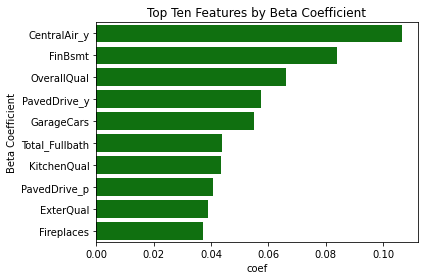

In [97]:
# make plot
print(mlr.intercept_)
labels = ['Central Air','Finished Bsmt','Overall Qual','Fully Paved D-way','Garage Cars','Full Baths','Kitchen Qual','Partly Paved D-way','Exterior Qual','Fireplaces']
# pd.DataFrame(mlr.coef_, index=mlr_Xtrain.columns).sort_values(0, ascending=False).head(10).plot.bar(legend=False)
mlr_coef = pd.DataFrame( mlr.coef_, index=mlr_Xtrain.columns, columns = ['coef'])
mlr_coef_top10 = mlr_coef.sort_values('coef', ascending=False).head(10) 
sns.barplot(x = mlr_coef_top10['coef'], y = mlr_coef_top10.index, color = 'green')
plt.title('Top Ten Features by Beta Coefficient')
plt.ylabel('Beta Coefficient')
plt.tight_layout()
# plt.xticks(np.arange(10), labels=labels)
# plt.show()
# plt.savefig("../output/mlr_top10_features.png")
plt.savefig("../output/mlr_top10_features_horizontal.png")
# mlr_coef_top10

In [136]:
!pip install pyLDAviz

     |████████████████████████████████| 24.2MB 4.9MB/s eta 0:00:01    |█▋                              | 1.3MB 2.3MB/s eta 0:00:11
     |████████████████████████████████| 112kB 8.6MB/s eta 0:00:01
     |████████████████████████████████| 133kB 8.5MB/s eta 0:00:01
     |████████████████████████████████| 71kB 7.7MB/s eta 0:00:01
     |████████████████████████████████| 6.2MB 9.1MB/s eta 0:00:01     |███████                         | 1.4MB 9.1MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.0.0-cp37-none-any.whl size=101343 sha256=ecadcc880dd3938e723e3379a89cf8cd4b61e6b544b724913cd9fbf3fde60a19
  Stored in directory: /Users/luyu/Library/Caches/pip/wheels/27/65/38/8d7f5fe8d7afb4e4566587b2d1933cec185fba19257836c943
Successfully built smart-open
